In [1]:
# Load necessary modules
import numpy as np
np.random.seed(1)
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import plotly.express as px
import pickle
from scipy.stats import kurtosis,skew,norm,kstest,spearmanr
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
import xgboost as xgb
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential
import warnings
warnings.filterwarnings('ignore')

## Loading the data
Loads all the data in a numpy array and dumps it in a pickle file for faster loading in the future from the pickle file.

In [2]:
def load_from_csv(DIR,no_of_samples,no_of_cols):
    """
    Loads the data from CSV files present in the given directory into a numpy nd-array.
    
    INPUT: 
        DIR: Directory name
        no_of_samples: No. of samples in each csv file
        no_of_cols: No. of columns in each csv file
    RETURNS:
        loaded_values: Numpy array of the loaded values.
    NOTE:
        Requires numpy
        
    """
    filenames = [name for name in os.listdir(DIR)]
    
    loaded_values = np.zeros([len(filenames), no_of_samples, no_of_cols])
    
    filenames = sorted(filenames)
    
    for i,file in  tqdm (enumerate(filenames),  desc="Reading Data",ascii=False, ncols=100, total=len(filenames)):
        loaded_values[i:i+1,:,:] = np.fromfile(os.path.join(DIR, file), dtype=np.float, sep="\t").reshape(no_of_samples,no_of_cols)
    
    return loaded_values
def load_raw_data(DIR,filename,no_of_samples,no_of_cols):
    """
    Loads the data from CSV file, if not already loaded and dumps it into a pickle file for faster loading in future.
    
    INPUT:
        DIR: directory in which the csv files are present
        filename: the name of the pickle file in which the data is to be dumped
        no_of_samples: No. of samples in each csv file
        no_of_cols: No. of columns in each csv file
        
    """
    
    if filename in os.listdir("."):
        print("data already loaded.")
    else:
        x = load_from_csv(DIR,no_of_samples,no_of_cols)
        with open(filename, "wb") as file:
            pickle.dump(x, file)

In [3]:
load_raw_data(DIR = '2nd_test/',filename = "data.pkz",no_of_samples=20480,no_of_cols=4)

data already loaded.


## Feature extraction
### Time domain features:
Mean absolute value, Std dev, Median, Max absolute value, Skewness, Kurtosis, RMS, Form factor,
Zero Crossing rate
### Frequency domain features:
1.Mean of the magnitude spectrum <br>
2.kurtosis of the magnitude spectrum <br>
3.Homogenity <br>
4.Mean of the magnitudes of frequency in the range (inner race fault freq - 10,inner race fault freq + 10) (if the
height of the peak in this range increases, the mean will also increase which may be a sign of inner race defect)<br>
5.Mean of the magnitudes of frequency in the range (outer race fault freq - 10,outer race fault freq + 10)<br>
6.Mean of magnitudes of higher frequences (when a fault occurs, there is an increase in magnitude of higher frequencies). The higher frequencies are divided into bins of 6 starting from 1000Hz to 10000Hz.

In [4]:
def sign(arr):
    """
    Returns a numpy array containing 1,0 and -1. 1 represents positive numbers,-1 represents negative numbers and 0 represents the number zero.
    
    INPUT: 
        arr: a numpy array
    RETURNS:
        sign_arr: a numpy array of 1s,0s and -1s.
        
    Eg:
        In: sign(np.array([ 1, 2, -1, -2, 0, -2]))
        Out: array([ 1,  1, -1, -1,  0, -1])
        
    """
    sign_arr = np.where(arr>0,1,np.where(arr<0,-1,0))
    return sign_arr

In [5]:
def zero_crossings(data,threshold = 0.015):
    """
    Calculates the no. of zero crossings in given data.
    
    INPUT:
        data: a 1-D numpy array
        threshold: Required minimum difference between consecutive entries in the data (useful in case of noisy data),default value is 0.015
    RETURNS:
        the no. of zero crossings
    
    Eg:
        In: data = np.array([1,-1,2,3])
            print(zero_crossings(data))
        Out: 2.0
        
    """
    a,b = data[:-1],data[1:] 
    
    a1,b1 = sign(a),sign(b)
    
    diff = abs(a-b)          #Taking difference between consecutive values
    
    a1,b1 = a1[diff>=threshold],b1[diff>=threshold]
    
    zc = np.floor(np.sum(abs(a1-b1))/2) #Opposite signs get added up to 2 and finally we divide by 2 to get our ans
    return zc

In [6]:
def frequency_domain(raw_data,sampling_rate):
    """
    Extracts frequency domain features which are: mean, kurtosis, homogenity, amplitudes around inner and outer race fault frequencies, mean of the magnitudes of higher frequencies.
    
    INPUT:
        raw_data: a numpy array of shape (n,m),i.e (Total no. of files, No. of samples in each file)
        sampling_rate: the rate at which the data is sampled
    RETURNS:
        fft_features: a list of extracted frequency domain features
        
    """
    fft_features = []
    
    fourier_transform = np.fft.fft(raw_data) # Calculates the discrete fourier transform
    
    fft_freq = np.fft.fftfreq(raw_data.shape[-1])*sampling_rate  # Calculates the discrete fourier transform sample frequencies
    
    magnitudes = np.abs(fourier_transform) # Gets the magnitudes of the frequencies
    
    # Since the frequency spectrum is symmetrical, we consider frequencies from 0 to half of sampling rate
    fft_features.append(magnitudes[:,(fft_freq>0)&(fft_freq<=(sampling_rate//2))].mean(axis=1).tolist()) # Mean
    
    fft_features.append(kurtosis(magnitudes[:,(fft_freq>0)&(fft_freq<=(sampling_rate//2))],axis=1).tolist()) # Kurtosis
    
    # Homeginity = max/mean
    fft_features.append((magnitudes[:,(fft_freq>0)&(fft_freq<=(sampling_rate//2))].max(axis=1)/magnitudes[:,(fft_freq>0)&(fft_freq<=(sampling_rate//2))].mean(axis=1)).tolist())
    
    # Checking the mean of magnitudes around the inner and outer race fault frequencies
    irfault_freq,orfault_freq = 500,230
    fft_features.append(magnitudes[:,(fft_freq>=irfault_freq-10)&(fft_freq<=irfault_freq+10)].mean(axis=1).tolist())
    fft_features.append(magnitudes[:,(fft_freq>=orfault_freq-10)&(fft_freq<=orfault_freq+10)].mean(axis=1).tolist())
    
    # Checking the mean of magnitudes of higher frequencies (>1000)
    bins = [2500,4000,5500,7000,8500,10000]
    for i in range(len(bins)-1):
        fft_features.append(magnitudes[:,(fft_freq>bins[i]) & (fft_freq<=bins[i+1])].mean(axis=1).tolist())
        
    return fft_features

def time_domain(raw_data):
    """
    Extracts time domain features which are: mean absolute value, stddev, median, max, skewness, kurtosis, RMS value, zero crossing rate,form factor
    
    INPUT:
        raw_data: a numpy array of shape (n,m),i.e (Total no. of files, No. of samples in each file)
    RETURNS:
        t_features: a list of time domain features
        
    """
    t_features = []
    
    t_features.append(abs(raw_data).mean(axis=1).tolist()) # Mean absolute value
    
    t_features.append(raw_data.std(axis=1).tolist())  # standard deviation
    
    t_features.append(np.median(raw_data,axis=1).tolist())  # median
    
    t_features.append(raw_data.max(axis=1).tolist())  # Max
    
    t_features.append(skew(raw_data,axis=1).tolist())  # Skewness
    
    t_features.append(kurtosis(raw_data,axis=1).tolist())  # Kurtosis
    
    rms = np.sqrt(np.sum(raw_data**2,axis=1)/raw_data.shape[1])  # RMS value
    t_features.append(rms.tolist())
    
    t_features.append((rms/raw_data.mean(axis=1)).tolist())  # Form factor = RMS/mean
    
    zcr = np.zeros(raw_data.shape[0])
    for i in range(raw_data.shape[0]):    # Calculating zero crossing rate
        zcr[i] = zero_crossings(raw_data[i])
    t_features.append(zcr.tolist())
    
    return t_features

def feature_extraction(filename,sampling_rate):
    """
    Extracts time and frequency domain features for each of the bearings from scratch(if not extracted already) and dumps the extracted features in a pickle for faster loading in future.
    
    INPUT:
        filename: the name of the pickle file in which the data was dumped previously
        sampling_rate: the rate at which the data was sampled
    RETURNS:
        bearings: a list of numpy arrays consisting of features for each bearing
        
    """
    with open(filename,"rb") as file:
        raw_data = pickle.load(file)
    bearings = []
    for i in range(4):
        if "bearing"+str(i)+".pkz" in os.listdir("."):
            print(f'Loading bearing {i} features from pickle.')
            with open("bearing"+str(i)+".pkz","rb") as file:
                bearings.append(pickle.load(file))
        else:
            print(f'Extracting bearing {i} features from scratch.')
            features = time_domain(raw_data[:,:,i])
            features.extend(frequency_domain(raw_data[:,:,i],sampling_rate))
            features = np.array(features).T
            bearings.append(features)
            with open("bearing"+str(i)+".pkz","wb") as file:
                pickle.dump(bearings[i],file)
    return bearings

In [7]:
bearings = feature_extraction(filename = "data.pkz",sampling_rate=20000)

Loading bearing 0 features from pickle.
Loading bearing 1 features from pickle.
Loading bearing 2 features from pickle.
Loading bearing 3 features from pickle.


## Functions that are required for data preparation, calculating errors, detecting anomaly, etc.

In [8]:
def scale(data,test_size=0.5, scaling_technique = 'robust'):
    """
    Scales the data with respect to the choice of scaler passed. Fits the scaler on training data and uses it to transform the entire data.
    
    INPUT:
        data: Data to be scaled
        test_size: Default 0.5
        scaling_technique: {"robust","minmax","standard"}, default = "robust"
    RETURNS:
        scaler: the scaler object
        values: scaled data
    NOTE:
        Requires sklearn
        
    """
    train_size = int(data.shape[0]*(1-test_size)) # Get the train length
    
    if scaling_technique == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_technique == 'standard':
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
        
    scaler.fit(data[:train_size])   # Fit on training data
    
    values = scaler.transform(data)
    
    return scaler,values

def split_sequences(data, time_steps):
    """
    Used to build input and output sequences in which time_steps no. of points are used as input and the immediate next point is the output.
    
    INPUT:
        data: A 2-D numpy array
        time_steps: No. of timesteps to use as input.
    RETURNS:
        X: numpy array of shape(no_of_samples-time_steps,time_steps,no_of_features) 
        y: numpy array of shape(no_of_samples-time_steps,1)
        
    Eg:
  (i)   In: data = np.array([1,2,3,4,5,6]).reshape(-1,1)
            X,y = split_sequences(data,3)
            print(f'Input = {X}')
            print(f'Output = {y}')
        Out: Input = [[[1.]
                       [2.]
                       [3.]]

                      [[2.]
                       [3.]
                       [4.]]

                      [[3.]
                       [4.]
                       [5.]]]
            Output = [[4]
                      [5]
                      [6]] 
  (ii)  In: data = np.array([[1,2],[3,4],[5,6],[7,8],[9,10]])
            X,y = split_sequences(data,3)
            print(f'Input = {X}')
            print(f'Output = {y}')
        Out: Input = [[[1. 2.]
                       [3. 4.]
                       [5. 6.]]

                      [[3. 4.]
                       [5. 6.]
                       [7. 8.]]]
             Output = [[ 7  8]
                       [ 9 10]]
                       
    """
    X = np.zeros((data.shape[0]-time_steps,time_steps,data.shape[-1]))
    
    for i in range(data.shape[0]-time_steps):
        X[i,:,:] = data[i:i+time_steps,:]
        
    y = data[time_steps:]
    
    return X,y

def split_data(X,y, test_size = 0.5):
    """
    Splits the input and target data into train and test sets.
    
    INPUT:
        X: a numpy array
        y: the target numpy array
        test_size: Default 0.5
    RETURNS:
        X_train: training input
        X_test: testing input
        y_train: training output
        y_test: testing output
        
    """
    length = X.shape[0]
    X_train = X[:int(-length*test_size)]
    y_train = y[:int(-length*test_size)]
    X_test = X[int(-length*test_size):]
    y_test = y[int(-length*test_size):]
    return X_train, X_test, y_train, y_test

def prepare_data(data,time_steps,test_size=0.5,scaling_technique = 'robust'):
    """
    Function to scale the data, build input and output sequences, and split the processed data into train and test sets.
    
    INPUT:
        data: a 2-D numpy array
        time_steps: No. of timesteps to use as input.
        test_size: Default 0.5
        scaling_technique: {"robust","minmax","standard"}, default = "robust"
    RETURNS: 
        scaler: the scaler object
        X_train: training input
        X_test: testing input
        y_train: training output
        y_test: testing output
        
    """
    scaler,scaled_data = scale(data,test_size,scaling_technique)  # First the data is scaled
    
    X,y = split_sequences(scaled_data,time_steps)   # Build the input and output sequences from the scaled data
    
    X_train, X_test, y_train, y_test = split_data(X,y,test_size)   # Split X,y into train and test sets
    
    return scaler,X_train, X_test, y_train, y_test

def build_model(X_train,y_train,timesteps,lstm1_units = 100,lstm2_units = 50,learning_rate = 0.01,
                batch_size = 30,epochs = 100,validation_size = 0.2,verbose = 1):
    """
    Builds a stacked LSTM model.
    
    INPUT:
        X_train: A 3-D numpy array of shape (no_of_samples,timesteps,no_of_features)
        y_train: A 2-D numpy array of shape (no_of_samples,no_of_features)
        timesteps: Timesteps to use as input, should be same as X_train.shape[1]
        lstm1_units: No. of hidden units in 1st layer of LSTM, default = 100
        lstm2_units: No. of hidden units in 2nd layer of LSTM, default = 50
        learning_rate: Learning rate for adam optimizer, default = 0.01
        batch_size: Batch size to use while fitting the model, default = 30
        epochs: No. of times to work through the entire training set, default = 100
        validation_size: Between 0 to 1, default 0.2
        verbose: {0,1},whether to display the training process or not, default = 1.
    RETURNS:
        model: stacked LSTM model
        hist: history of the model (captures loss,validation loss over the training period)
        
    """
    model = Sequential()
    
    # 1st LSTM layer, relu is used as activation function.
    model.add(LSTM(lstm1_units,activation='relu',return_sequences=True,input_shape=(timesteps,X_train.shape[-1])))
    
    model.add(LSTM(lstm2_units))
    
    model.add(Dropout(0.3))   # adding dropout for preventing overfitting
    
    model.add(Dense(y_train.shape[-1]))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='mse',optimizer=optimizer)   # MSE is used as loss function
    
    hist = tf.keras.callbacks.History()
    
    hist = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=validation_size,shuffle=True,verbose=verbose)
    
    # Monitor the validation loss and stop training after 20 epochs of no reduction in loss greater than 0.001
    # Restores the weights corresponding to the epoch with lowest validation loss
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=0, mode='min',
                                   restore_best_weights=True)]
    return model,hist

In [9]:
def plot_pred_and_actual(data,model,scaler,timesteps,features,num_rows = 3,num_cols = 3,figsize = (15,12)):
    """
    Plots predicted and actual values of each of the features in the data.
    
    INPUT:
        data: 2-D numpy array of shape (n_samples,n_features)
        model: Trained model to use for prediction
        scaler: scaler object fitted on training data
        timesteps: Timesteps to use as input
        features: A list of feature names
        num_rows: No. of rows in the subplot, default = 3
        num_cols: No. of columns in the subplot, default = 3
        figsize: (float,float) width, height in inches, default = (15,12)
    NOTE:
        Requires matplotlib
    """
    scaled_data = scaler.transform(data) # scale the entire data
    
    X,y = split_sequences(scaled_data,timesteps)  # Get the input and output sequences
    
    y_pred = model.predict(X)   # Make predictions
    
    # Plot the predicted and actual values
    fig=plt.figure(figsize=figsize)
    
    plot_no = 1
    
    for col in range(data.shape[-1]):
        plt.subplot(num_rows,num_cols,plot_no)
        plt.plot(y[:,col],label='True')
        plt.plot(y_pred[:,col],label='Predicted')
        plt.ylabel(features[col])
        plt.xlabel('Timesteps')
        plt.title('Predicted vs actual')
        plot_no += 1
        

    for ax in fig.axes:
        line, label = ax.get_legend_handles_labels()
    
    by_label = dict(zip(label,line))
    
    fig.legend(by_label.values(), by_label.keys(),bbox_to_anchor = (0.8, 1))

In [10]:
def f_calculate_thresholds(combined_uncertainties, phi=0.95):

    """

    Calculates EDMF thresholds for provided target reliability of identification



    Developed by :   Sai G.S. Pai (ETH Singapore)

    Contact :        saiganesh89@gmail.com

    Date:            June 30, 2020



    INPUTS:

        combined_uncertainties : numpy array with each column containing combined uncertainty samples for each measurement point

        phi : target reliability of identification



    OUTPUTS:

        thresholds : numpy array with each row containing lower and upper bound uncertainty threshold values for each measurement point



    NOTE:

        Requires numpy



    """

    import numpy as np

    # set phi

    phi = float(phi) ** (1 / combined_uncertainties.shape[1])       # float to ensure value is numeric not list

#     print("Phi = ", phi)        # Check Phi



    # Initialize search

    step_size = 1

    length = int((1 - phi) * combined_uncertainties.shape[0] / step_size)

    perc_calculation = np.zeros(shape=(length, 3))

    thresholds = np.zeros(shape=(combined_uncertainties.shape[1], 2))



#     print("*** Starting search for thresholds ***")

    for sens_num in range(0, combined_uncertainties.shape[1]):

        temp_array = np.sort(combined_uncertainties[:, sens_num])       # sort samples in ascending order

        for iter_num in range(0, length):

            temp = np.zeros(shape=(1, 3))

            endA_init_samples = np.arange(0, 1 + (iter_num * step_size))        # end A is for the lower bound

            endB_init_samples = np.arange(len(endA_init_samples), len(endA_init_samples) +

                                          np.around(phi * len(temp_array)), dtype=int)      # end B is for the upper bound

            temp[0, 0] = np.max(temp_array[endA_init_samples])

            temp[0, 1] = np.max(temp_array[endB_init_samples])

            # calculate percentile range for each step

            temp[0, 2] = np.max(temp_array[endB_init_samples]) - np.max(temp_array[endA_init_samples])

            perc_calculation[iter_num, :] = temp



        threshold_idx = np.where(perc_calculation[:, 2] ==

                                 np.amin(perc_calculation[:, 2]))       # get index of lowest percentile range

        # EDMF thresholds corresponding to lowest percentile range

        thresholds[sens_num, :] = perc_calculation[threshold_idx, [0, 1]]



#     print(thresholds)



    return thresholds

    # numpy array with size number_measurements x 2



In [44]:
def calc_errors(data,model,scaler,timesteps,features,healthy_data_len,num_rows = 3,num_cols = 3,figsize = (15,15)):
    """
    Calculates standardised errors between predicted and actual values and plots the PDF of the errors of the healthy portion.
    
    INPUT:
        data: 2-D numpy array of shape (n_samples,n_features)
        model: Trained model to use for prediction
        scaler: scaler object fitted on training data
        timesteps: Timesteps to use as input
        features: A list of feature names
        healthy_data_len: Length of healthy portion of data
        num_rows: No. of rows in the subplot, default = 3
        num_cols: No. of columns in the subplot, default = 3
        figsize: (float,float) width, height in inches, default = (15,15)
    RETURNS:
        errors_std: 2-D numpy array of shape (n_samples,n_features)
        normal_errors_std: 2-D numpy array of shape (healthy_data_len,n_features)
        
    """
    scaled_data = scaler.transform(data)  # scale the data
    
    X,y = split_sequences(scaled_data,timesteps)   # Get the input and output sequences
    
    y_pred = model.predict(X)   # Make predictions
    
    errors = (y_pred-y)   # Compute errors 
    
    normal_errors = errors[:healthy_data_len]   # Store errors from healthy part
    
    errors_std = (errors-normal_errors.mean(axis=0))/normal_errors.std(axis=0)   # Standardize the errors
    
    normal_errors_std = errors_std[:healthy_data_len]  
    
    plt.figure(figsize=figsize)
    
    plot_no = 1
    
    # Plotting the PDF
    df = pd.DataFrame(normal_errors_std,columns=features)

    for col in df.columns:
        plt.subplot(num_rows,num_cols,plot_no)
        sns.kdeplot(data=df,x=col,fill=True)
        plot_no += 1
        
    return errors_std,normal_errors_std

def KStest(data,features):
    """
    Performs KS Test on th data to check for normality.
    
    INPUT:
        data: 2-D numpy array of shape (n_samples,n_features)
        features: A list of feature names
        
    """
    for i in range(data.shape[-1]):
        
        stats,pval = kstest(data[:,i],'norm')  # Using scipy KS Test function
        
        print(f'p-value for errors of feature {features[i]}: {pval}')
        
        # Reject null hypothesis if p-value is less than or equal to 0.05
        if pval>0.05:
            print('Do not reject null hypothesis (The distribution of RV is normal)\n')
        else:
            print("Reject the null hypothesis (RV doesnt follow a normal distribution)\n")
            
def QQPlot(data,features):
    """
    Quantile-Quantile plot of data vs the normal distribution.
    
    INPUT:
        data: A 2-D numpy array of shape (n_samples,n_features), must be standardized
        features: A list of feature names
        
    """
    for i in range(data.shape[-1]):
        print(features[i])
        fig = sm.qqplot(data[:,i],line='45') 
        plt.show()

def anomaly(normal_errors,errors,normal_dist_errors,feature_names,timewindow_len,level0_threshold,level1_threshold,min_delta = 0.01,num_rows = 3,num_cols = 3,figsize = (15,12),verbose = 1):
    """
    Function used to detect anomaly. A level 0 warning is triggered if within a time window the no. of times the errors continuously cross the upper and lower bounds is greater than or equal to the level 0 threshold.
    If we get continuously level1_threshold amount of level 0 warnings, then the level 1 warning is triggered, i.e anomaly is detected at that timestep. 
    
    INPUT:
        normal_errors: 2-D numpy array of shape (len_of_healthy_data,n_features), standardised errors till the healthy portion of the data
        errors: 2-D numpy array of shape (n_samples,n_features), standardised errors from the entire data
        normal_dist_errors: A list specifying True for normal_errors which are normally distributed else false
        feature_names: A list of feature names
        timewindow_len: Length of the time window to watch
        level0_threshold: Threshold for level 0 warning
        level1_threshold: Threshold for level 1 warning
        min_delta: Minimum difference between error and upper/lower bound (Helps to reduce the no. of false level 0 warnings)
        num_rows: No. of rows in the subplot, default = 3
        num_cols: No. of columns in the subplot, default = 3
        figsize: (float,float) width, height in inches, default = (15,12)
        verbose: Whether or not to print the timesteps at which warnings are triggered, default = 1
    
    """
    fig=plt.figure(figsize=figsize)
    plot_no = 1
    lines = []
    labels = []
    
    for col in range(normal_errors.shape[-1]):
        plt.subplot(num_rows,num_cols,plot_no)
        
        if normal_dist_errors[col]: 
            # If errors are normally distributed, calculate lower and upper bound using +3,-3 std devs.
            mean = normal_errors[:,col].mean()
            std = normal_errors[:,col].std()
            upper = mean + 3*std
            lower = mean - 3*std
        else:
            # else calculate the 99th and 1st percentiles as upper and lower bounds consecutively.
            thresholds = f_calculate_thresholds(normal_errors[:,col].reshape(-1,1),0.99)
            thresholds = np.squeeze(thresholds)
            lower,upper = thresholds[0],thresholds[1]
            
        lines.append(plt.axhline(lower,ls='--',label = 'Error thresholds',color = 'limegreen'))
        lines.append(plt.axhline(upper,ls='--'))
        lines.append(plt.plot(errors[:,col],ls='-',color = 'dodgerblue'))
        lines.append(plt.xlabel('Timesteps'))
        lines.append(plt.ylabel('Errors'))
        
        level0 = 0    # Maintain a counter to track the level 0 warnings
        
        i = 0
        
        level0_signal = False
        
        while i < len(errors)-timewindow_len:
            # Consider the errors within the time window
            temp_errors = errors[i:i+timewindow_len,col]
            mask1 = (temp_errors > upper) & (abs(temp_errors - upper) > min_delta)   # For crossing upper bound
            mask2 = (temp_errors < lower) & (abs(temp_errors - lower) > min_delta)   # For crossing lower bound
            mask = mask1 | mask2   # Either crosses upper or lower bound
            
            res,temp_res = 0,0    # For counting the no. of times errors continuously cross the bounds
            last = -1   # Index of the last error that crosses the bounds
            
            for j in range(len(mask)):
                if mask[j]:
                    temp_res += 1
                    if temp_res > res:
                        res = temp_res
                        last = j
                else:
                    temp_res = 0
            
            if res >= level0_threshold:  # If res crosses level0_threshold trigger a warning
                lines.append(plt.axvspan(i,i+timewindow_len,facecolor='red',label = 'Level 0 warning'))
                level0 += 1  # Increment level0 counter
                
                if verbose and not level0_signal:  # if level 0 warning hasnt been triggered it, then trigger the warning.
                    level0_signal = True
                    print(f'Level 0 warning given at {i}th timestep') 
                
                i += last+1
            else:
                level0 = 0
                
                if verbose and level0_signal:   # If level 0 warning had been triggered, then stop the warning.
                    level0_signal = False
                    print(f'Level 0 warning dies at {i}th timestep')
                    
                i+=1
                
            if level0 >= level1_threshold:   # If level0 counter crosses level 1 threshold, trigger level 1 warning and break
                if verbose:
                    print(f'Level 1 warning given at {i}th timestep')
                lines.append(plt.axvspan(i,len((errors)-timewindow_len),facecolor='black',label = 'Level 1 warning'))
                break
                
#         lines.append(plt.xlabel(feature_names[col]))
        plot_no += 1
        
    for ax in fig.axes:
        line, label = ax.get_legend_handles_labels()
    by_label = dict(zip(label, line))
    fig.legend(by_label.values(), by_label.keys(),bbox_to_anchor = (0.8, 1))

In [12]:
def outer_race_defect(normal_errors,errors,is_normal,timewindow_len,level0_thresh,level1_thresh,min_delta = 0.01,num_rows = 1,num_cols = 1,figsize = (6,4),verbose = 0):
    """
    Function to detect the timestep at which outer race defect occurs. If within the time window, the no. of times the error continuously crosses the lower/upper bound is greater than the level0 threshold, then a counter is incremented.
    When the value of the counter crosses level 1 threshold, outer race defect is detected.
    
    INPUT:
        normal_errors: 2-D numpy array of shape (len_of_healthy_data,1), standardised errors till the healthy portion of the data
        errors: 2-D numpy array of shape (n_samples,1), standardised errors from the entire data
        is_normal: {True, False}, whether the normal_errors follow a normal distribution or not
        timewindow_len: Length of the time window to watch
        level0_thresh: Threshold for incrementing counter
        level1_thresh: Threshold for detecting outer race
        min_delta: Minimum difference between error and upper/lower bound 
        num_rows: No. of rows in the subplot, default = 1
        num_cols: No. of columns in the subplot, default = 1
        figsize: (float,float) width, height in inches, default = (6,4)
        
    """
    fig=plt.figure(figsize=figsize)
    plot_no = 1
    plt.subplot(num_rows,num_cols,plot_no)
    
    if is_normal:
        # If errors are normally distributed, calculate lower and upper bound using +3,-3 std devs.
        mean = normal_errors.mean()
        std = normal_errors.std()
        upper = mean+3*std
        lower = mean-3*std
    else:
        # else calculate the 99th and 1st percentiles as upper and lower bounds consecutively.
        thresholds = f_calculate_thresholds(normal_errors.reshape(-1,1),0.99)
        thresholds = np.squeeze(thresholds)
        lower,upper = thresholds[0],thresholds[1]
        
    lines = []
    labels = []
    lines.append(plt.axhline(upper,ls='--',label = 'thresholds',color='limegreen'))
    lines.append(plt.axhline(lower,ls='--'))
    lines.append(plt.plot(errors))
    lines.append(plt.xlabel('Time step'))
    lines.append(plt.ylabel('error'))
    level0 = 0   # Level 0 counter
    i = 0
    
    level0_signal = False
    while i < (len(errors)-timewindow_len):
        # Consider the errors within the time window
        temp_errors = errors[i:i+timewindow_len]
        mask1 = (temp_errors > upper) & (abs(temp_errors-upper) > min_delta)
        mask2 = (temp_errors < lower) & (abs(temp_errors-lower) > min_delta)
        mask = mask1 | mask2
        
        res,temp_res = 0,0  # For counting the no. of times errors continuously cross the bounds
        last = -1   # Index of the last error that crosses the bounds
            
        for j in range(len(mask)):
            if mask[j]:
                temp_res += 1
                if temp_res > res:
                    res = temp_res
                    last = j
            else:
                temp_res = 0
                
        if res >= level0_thresh:
            level0+=1
            lines.append(plt.axvspan(i,i+timewindow_len,facecolor='red',label='Level 0 warning'))
            if verbose and not level0_signal:  # if level 0 warning hasnt been triggered it, then trigger the warning.
                level0_signal = True
                print(f'Level 0 warning given at {i}th timestep') 
            i += last+1
        else:
            level0 = 0
            if verbose and level0_signal:   # If level 0 warning had been triggered, then stop the warning.
                level0_signal = False
                print(f'Level 0 warning dies at {i}th timestep')
            i += 1
            
        if level0 >= level1_thresh:  # Outer race defect is detected when level0 counter crosses level1 threshold
            print(f'At {i}th time window outer race defect is detected')
            lines.append(plt.axvspan(i,len((errors)-timewindow_len),facecolor='black',label='outer race defect'))
            break
            
    for ax in fig.axes:
        line, label = ax.get_legend_handles_labels()
    by_label = dict(zip(label, line))
    fig.legend(by_label.values(), by_label.keys(),bbox_to_anchor = (1.2, 1))

def inner_race_defect(normal_errors,errors,is_normal,timewindow_len,level0_thresh,level1_thresh,min_delta = 0.01,num_rows = 1,num_cols = 1,figsize = (6,4),verbose=0):
    """
    Function to detect the timestep at which inner race defect occurs. If within the time window, the no. of times the error continuously crosses the lower/upper bound is greater than the level0 threshold, then a counter is incremented.
    When the value of the counter crosses level 1 threshold, inner race defect is detected.
    
    INPUT:
        normal_errors: 2-D numpy array of shape (len_of_healthy_data,1), standardised errors till the healthy portion of the data
        errors: 2-D numpy array of shape (n_samples,1), standardised errors from the entire data
        is_normal: {True, False}, whether the normal_errors follow a normal distribution or not
        timewindow_len: Length of the time window to watch
        level0_thresh: Threshold for incrementing counter
        level1_thresh: Threshold for detecting inner race
        min_delta: Minimum difference between error and upper/lower bound 
        num_rows: No. of rows in the subplot, default = 1
        num_cols: No. of columns in the subplot, default = 1
        figsize: (float,float) width, height in inches, default = (6,4)
        
    """
    fig=plt.figure(figsize=figsize)
    plot_no = 1
    plt.subplot(num_rows,num_cols,plot_no)
    
    level0_signal = False
    if is_normal:
        # If errors are normally distributed, calculate lower and upper bound using +3,-3 std devs.
        mean = normal_errors.mean()
        std = normal_errors.std()
        upper = mean+3*std
        lower = mean-3*std
    else:
        # else calculate the 99th and 1st percentiles as upper and lower bounds consecutively.
        thresholds = f_calculate_thresholds(normal_errors.reshape(-1,1),0.99)
        thresholds = np.squeeze(thresholds)
        lower,upper = thresholds[0],thresholds[1]
        
    lines = []
    labels = []
    lines.append(plt.axhline(upper,ls='--',label = 'thresholds',color='limegreen'))
    lines.append(plt.axhline(lower,ls='--'))
    lines.append(plt.plot(errors))
    lines.append(plt.xlabel('Time step'))
    lines.append(plt.ylabel('error'))
    level0 = 0    # Level 0 counter
    i = 0
    
    while i < (len(errors)-timewindow_len):
        # Consider the errors within the time window
        temp_errors = errors[i:i+timewindow_len]
        mask1 = (temp_errors > upper) & (abs(temp_errors-upper) > min_delta)
        mask2 = (temp_errors < lower) & (abs(temp_errors-lower) > min_delta)
        mask = mask1 | mask2
        
        res,temp_res = 0,0  # For counting the no. of times errors continuously cross the bounds
        last = -1   # Index of the last error that crosses the bounds
        
        for j in range(len(mask)):
            if mask[j]:
                temp_res += 1
                if temp_res > res:
                    res = temp_res
                    last = j
            else:
                temp_res = 0
                
        if res >= level0_thresh:
            level0 += 1
            lines.append(plt.axvspan(i,i+timewindow_len,facecolor='red',label='Level 0 warning'))
            if verbose and not level0_signal:  # if level 0 warning hasnt been triggered it, then trigger the warning.
                level0_signal = True
                print(f'Level 0 warning given at {i}th timestep') 
            i += last+1
        else:
            level0 = 0
            if verbose and level0_signal:   # If level 0 warning had been triggered, then stop the warning.
                level0_signal = False
                print(f'Level 0 warning dies at {i}th timestep')
            i += 1
            
        if level0 >= level1_thresh:  # Inner race defect is detected when level0 counter crosses level1 threshold
            print(f'At {i}th time window inner race defect is detected')
            lines.append(plt.axvspan(i,len((errors)-timewindow_len),facecolor='black',label='inner race defect'))
            break
            
    for ax in fig.axes:
        line, label = ax.get_legend_handles_labels()
    by_label = dict(zip(label, line))
    fig.legend(by_label.values(), by_label.keys(),bbox_to_anchor = (1.2, 1))

In [13]:
def firstPrincipalComponent(data,healthy_data_len,test_size = 0.5,scaling_technique = 'robust'):
    """
    Performs PCA and returns the first principal component.
    
    INPUT:
        data: 2-D numpy array of shape (n_samples,n_features)
        healthy_data_len: Length of healthy portion of data
        test_size: Needed for scaling the data before performing PCA, default = 0.5
        scaling_technique: {'minmax','robust','standard'}, default = 'robust'
    RETURNS:
        data_pca: First principal component, 2-D numpy array of shape (n_samples,1)
    """
    scaler_pca,temp = scale(data[:healthy_data_len,:],test_size,scaling_technique)   # Get the scaler object
    
    data_scaled = scaler_pca.transform(data)   # scale the entire data
    
    pca = PCA(n_components=1)    
    
    pca.fit(data_scaled[:healthy_data_len,:])   # Fit pca object on healthy portion
    
    data_pca = pca.transform(data_scaled)    # Transform the entire data
    
    return data_pca

### Feature selection using xgboost
Xgboost is used to train the model and then the permutation importance for each feature is calculated. 

In [15]:
feature_names = ['mean_abs','std','median','max','skew','kurtosis','RMS','form_factor','zero_crossings',
                'freq_mean','freq_kurtosis','homogenity','irfaultfreqmag','orfaultfreqmag','2500-4000hz',
                 '4000-5500hz','5500-7000hz','7000-8500hz','8500-10000hz']

In [16]:
df = pd.DataFrame(bearings[0],columns=feature_names)

df['target'] = 0

df.loc[500:,'target'] = 1    # Consider unhealthy data after 500

X,y = df.iloc[:,:-1].values,df.iloc[:,-1].values

model = xgb.XGBClassifier(random_state=0)

model.fit(X,y)

[12:53:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
df.columns

Index(['mean_abs', 'std', 'median', 'max', 'skew', 'kurtosis', 'RMS',
       'form_factor', 'zero_crossings', 'freq_mean', 'freq_kurtosis',
       'homogenity', 'irfaultfreqmag', 'orfaultfreqmag', '2500-4000hz',
       '4000-5500hz', '5500-7000hz', '7000-8500hz', '8500-10000hz', 'target'],
      dtype='object')

In [18]:
df_selected = df.iloc[:,[0,7,8,14,17,19]]

In [19]:
for col in df_selected.columns[:-1]:
    scaler = MinMaxScaler()
    df_selected[col] = scaler.fit_transform(df_selected[col].values.reshape(-1,1))

In [20]:
df_selected

,mean_abs,form_factor,zero_crossings,2500-4000hz,7000-8500hz,target
0,0.126427,0.836675,0.724083,0.099321,0.106419,0
1,0.127896,0.819289,0.755443,0.102800,0.115923,0
2,0.130644,0.818076,0.731303,0.102798,0.111578,0
3,0.133330,0.814985,0.734461,0.110950,0.109704,0
4,0.133125,0.816521,0.743486,0.107506,0.110656,0
...,...,...,...,...,...,...
979,1.000000,0.633193,0.864072,1.000000,0.958161,1
980,0.744016,0.760651,0.953525,0.571163,0.550316,1
981,0.773917,0.616775,0.914382,0.685999,0.576768,1
982,0.001523,0.843354,0.000000,0.000203,0.000543,1


In [21]:
model.score(X,y)

1.0

In [22]:
result = permutation_importance(model,X,y,n_repeats=10,random_state=0)
result.importances_mean

array([0.01473577, 0.        , 0.        , 0.00050813, 0.00213415,
       0.        , 0.        , 0.00060976, 0.0129065 , 0.00101626,
       0.        , 0.00294715, 0.00121951, 0.00081301, 0.00152439,
       0.03546748, 0.00477642, 0.00193089, 0.00193089])

#### As we can see the values of permutation importance are <= 3%, this is an indication that features are correlated, so we use spearman rank correlation to do hierarchical clustering and select a proper threshold and keep the first feature from each cluster

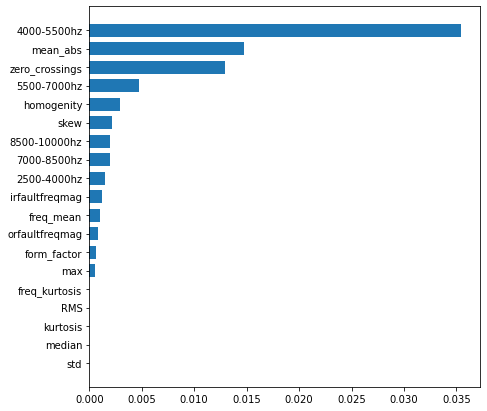

In [23]:
perm_sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(7,7))
indices = np.arange(0,len(result.importances_mean))
plt.barh(indices,result.importances_mean[perm_sorted_idx],height = 0.7)
plt.yticks(ticks = indices,labels=np.array(feature_names)[perm_sorted_idx])
plt.show()

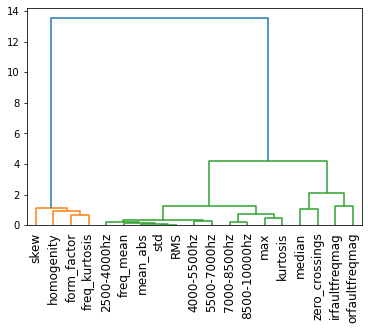

In [24]:
# Using spearman rank correlation and plotting the dendogram

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names, leaf_rotation=90
)

In [25]:
from collections import defaultdict

# Perform hierarchical clustering and include the first features of the clusters
cluster_ids = hierarchy.fcluster(corr_linkage,0.7, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
# 10 out of 19 features selected
selected_features    

[0, 2, 3, 4, 7, 8, 11, 12, 13, 17]

In [26]:
X = df.iloc[:,selected_features].values
y = df.iloc[:,-1].values
model2 = xgb.XGBClassifier(random_state=0)
model2.fit(X,y)

[12:53:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
model2.score(X,y)

1.0

In [28]:
feature_names = np.array(feature_names)
feature_names_0 = feature_names[selected_features]
feature_names_0

array(['mean_abs', 'median', 'max', 'skew', 'form_factor',
       'zero_crossings', 'homogenity', 'irfaultfreqmag', 'orfaultfreqmag',
       '7000-8500hz'], dtype='<U14')

#### We check the permutation importances of the selected features from the clusters, mean_abs has the highest value among them (around 40%). Median has permutation importances of 0. Apart from Inner and outer race fault frequencies, we include the other features in our model.

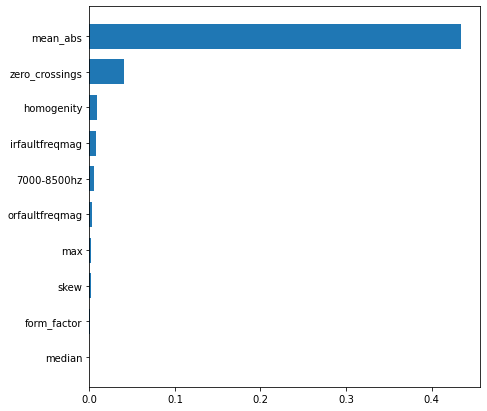

In [29]:
result2 = permutation_importance(model2,X,y,n_repeats=10,random_state=0)
perm_sorted_idx = result2.importances_mean.argsort()
plt.figure(figsize=(7,7))
indices = np.arange(0,len(result2.importances_mean))
plt.barh(indices,result2.importances_mean[perm_sorted_idx],height = 0.7)
plt.yticks(ticks = indices,labels=np.array(feature_names_0)[perm_sorted_idx])
plt.show()

In [30]:
feature_names

array(['mean_abs', 'std', 'median', 'max', 'skew', 'kurtosis', 'RMS',
       'form_factor', 'zero_crossings', 'freq_mean', 'freq_kurtosis',
       'homogenity', 'irfaultfreqmag', 'orfaultfreqmag', '2500-4000hz',
       '4000-5500hz', '5500-7000hz', '7000-8500hz', '8500-10000hz'],
      dtype='<U14')

In [31]:
# Including mean_abs, zero_crossings, 7000-8500 Hz,form factor and 2500-4000 Hz
# Not including homogenity as it is resulting in very high loss while training the LSTM
# Keeping ir and or fault frequency out of the feature list as two separate models are built for them

selected_features = [0,7,8,14,17]
features_names_selected = feature_names[selected_features]

# Final feature set
features_names_selected

array(['mean_abs', 'form_factor', 'zero_crossings', '2500-4000hz',
       '7000-8500hz'], dtype='<U14')

In [32]:
bearings0 = bearings[0][:,selected_features]
bearings1 = bearings[1][:,selected_features]
bearings2 = bearings[2][:,selected_features]
bearings3 = bearings[3][:,selected_features]

### Histogram plot of bearing 1 features

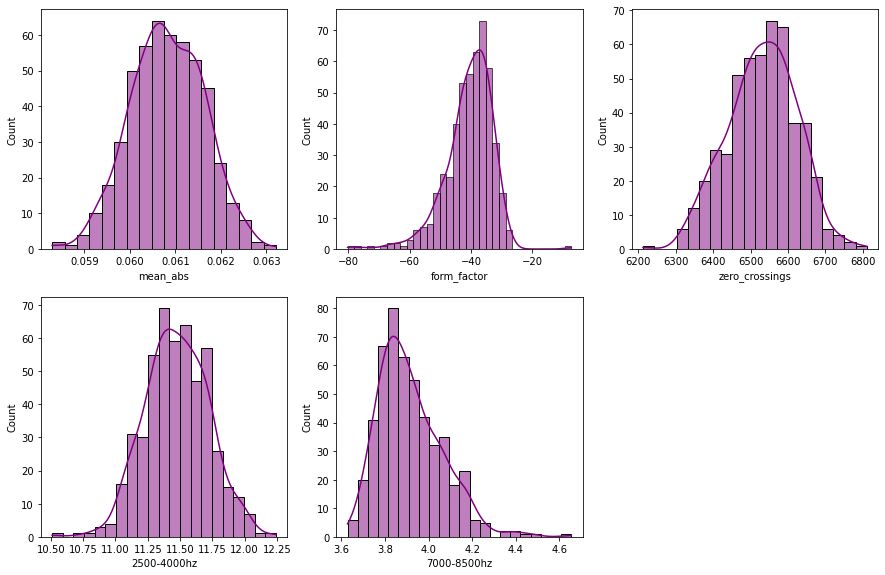

In [33]:
plt.figure(figsize=(15,15))
num_rows,num_cols = 3,3
plot_no = 1
for col in range(bearings0.shape[-1]):
    plt.subplot(num_rows,num_cols,plot_no)
    sns.histplot(bearings0[:500,col],kde=True,color = 'purple')
    plt.xlabel(features_names_selected[col])
    plot_no += 1

### Plot of bearing 1 features with time

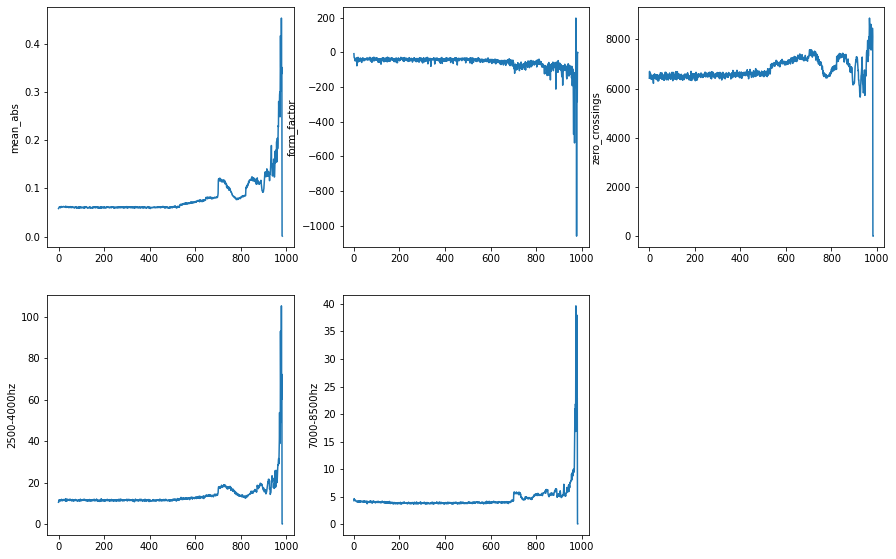

In [34]:
plt.figure(figsize=(15,15))
plot_no = 1
for col in range(bearings0.shape[-1]):
    plt.subplot(num_rows,num_cols,plot_no)
    plt.plot(bearings0[:,col])
    plt.ylabel(features_names_selected[col])
    plot_no += 1

# Bearing 1
Using 3 as input timesteps and predicting the immediate next timestep. We build an LSTM model using the healthy portion ,ie. uptil 500, use 20% of it as test set and minmax scaling is used.

In [35]:
scaler,X_train, X_test, y_train, y_test = prepare_data(bearings0[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model,hist = build_model(X_train,y_train,timesteps=3,lstm1_units=80,lstm2_units=50,batch_size=20,epochs=100,learning_rate=0.01,verbose=1)

In [36]:
# model.save('model0',save_format='h5')

In [37]:
model = tf.keras.models.load_model('model0')

In [38]:
# Checking the loss on test set
print(f'Loss on test data: {model.evaluate(X_test,y_test)}')

4/4 [==============================] - 1s 3ms/step - loss: 0.0182
Loss on test data: 0.01815461926162243


### Plotting the predicted and actual values of features for bearing 1

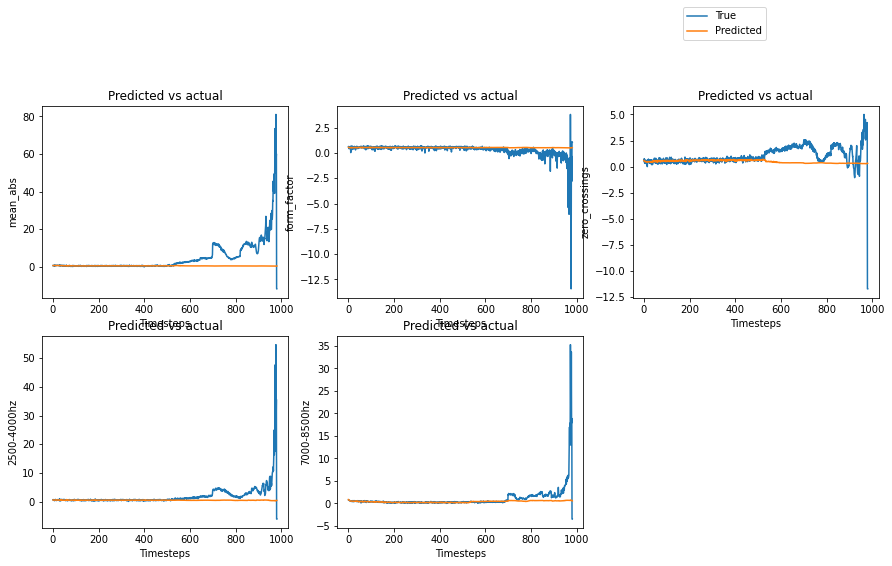

In [39]:
plot_pred_and_actual(bearings0,model,scaler,3,features_names_selected)

#### The errors (y_pred-y_true) are calculated but we only consider the errors from the healthy portion of the data for calculating thresholds. The errors are standardised using the mean and std of the error from the healty part.

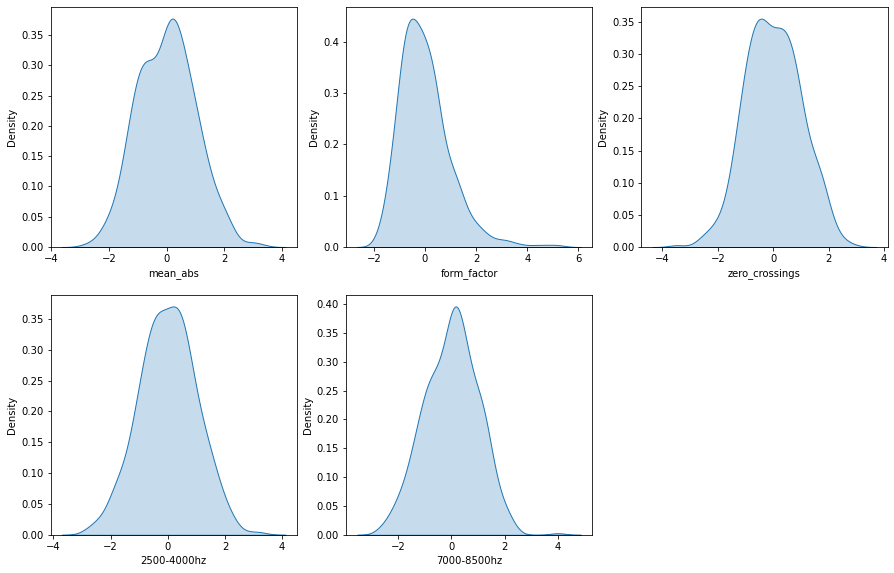

In [40]:
errors_std,normal_errors_std = calc_errors(bearings0,model,scaler,3,features_names_selected,500)

### Testing for normality using KS Test and QQ Plot

In [41]:
KStest(normal_errors_std,features_names_selected)

p-value for errors of feature mean_abs: 0.5022438280938009
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature form_factor: 0.0029247849943948726
Reject the null hypothesis (RV doesnt follow a normal distribution)

p-value for errors of feature zero_crossings: 0.5519428272170432
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature 2500-4000hz: 0.9902869898795593
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature 7000-8500hz: 0.623421821460448
Do not reject null hypothesis (The distribution of RV is normal)



mean_abs


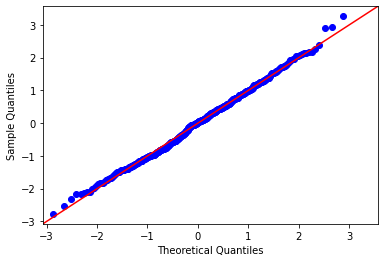

form_factor


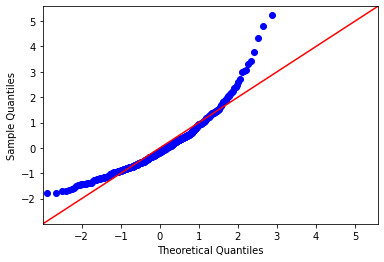

zero_crossings


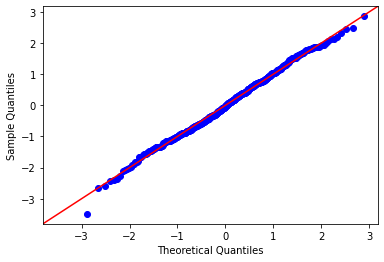

2500-4000hz


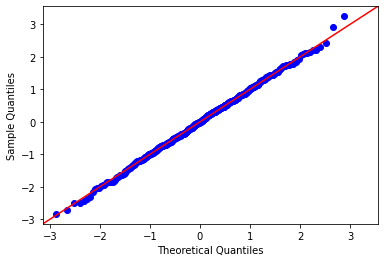

7000-8500hz


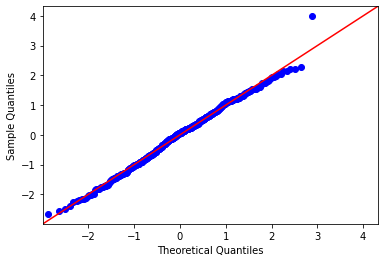

In [42]:
QQPlot(normal_errors_std,features_names_selected)

### Detecting anomaly
A level 0 warning is triggered and a counter is incremented whenever the errors cross the thresholds for 1 timestep in the entire time window of given length(here, 1). If the level 0 counter crosses the level1 threshold(here,12) a level 1 warning is triggered. Therefore, an anomaly is detected if we get a level 0 warning for continuously 2 hours.

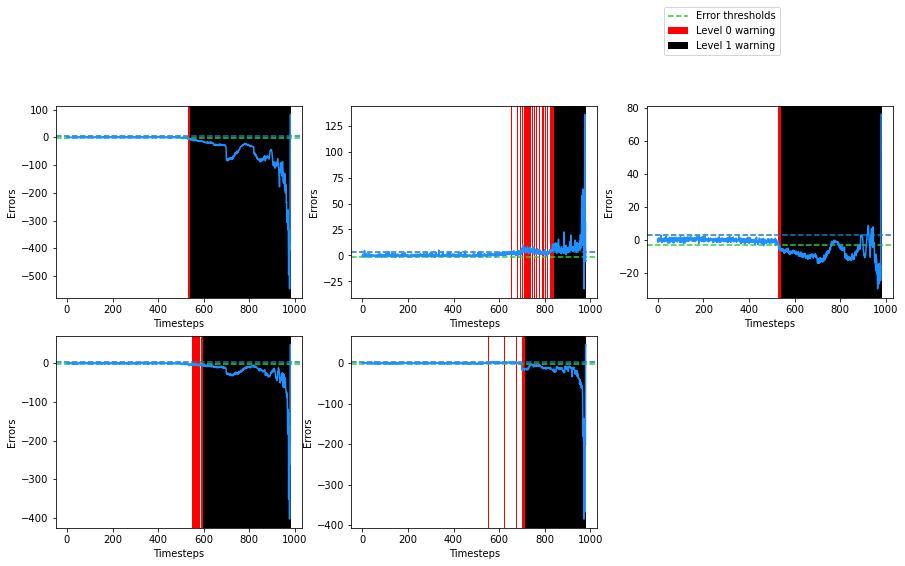

In [45]:
normal_dist_errors = [True,False,True,True,True]
anomaly(normal_errors_std,errors_std,normal_dist_errors,features_names_selected,1,level0_threshold=1,level1_threshold=12,min_delta=0,verbose=0)

## Combining features
We apply PCA and keep the first principal component(which has the maximal importance(variance)). The first PC is used to build a model and make predictions.

In [46]:
bearings0_pca = firstPrincipalComponent(bearings0,500,0.2,'minmax')   # Get the first principal component

In [47]:
# Build the model
scaler_pca,X_train_pca, X_test_pca, y_train_pca, y_test_pca = prepare_data(bearings0_pca[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_pca,hist_pca = build_model(X_train_pca,y_train_pca,timesteps=3,lstm1_units=90,lstm2_units=50,batch_size=30,epochs=100,learning_rate=0.01,verbose=1)

In [48]:
# model_pca.save('model_pca0',save_format='h5')

In [49]:
model_pca = tf.keras.models.load_model('model_pca0')

In [50]:
print(f'Loss on test data: {model_pca.evaluate(X_test_pca,y_test_pca)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0208
Loss on test data: 0.02075006067752838


### Plot predicted vs actual

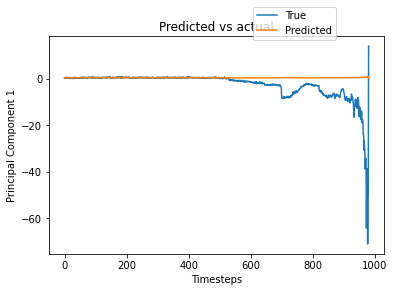

In [51]:
plot_pred_and_actual(bearings0_pca,model_pca,scaler_pca,3,['Principal Component 1'],num_rows=1,num_cols=1,figsize=(6,4))

### Calculate errors
errors_std_pca are the standardised errors of the entire data.<br> normal_errors_std_pca are the standardised errors from the healthy part

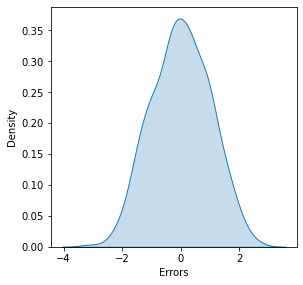

In [52]:
errors_std_pca,normal_errors_std_pca = calc_errors(bearings0_pca,model_pca,scaler_pca,3,['Errors'],500)

### Check for normality using KS Test and QQ Plot

p-value for errors of feature Principal Component 1: 0.799785158136431
Do not reject null hypothesis (The distribution of RV is normal)

Principal Component 1


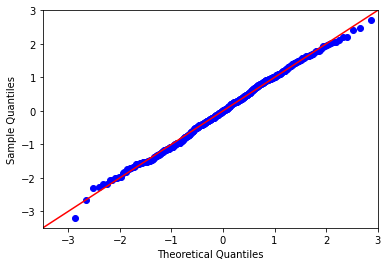

In [54]:
KStest(normal_errors_std_pca,['Principal Component 1'])
QQPlot(normal_errors_std_pca,['Principal Component 1'])

### Detecting anomaly
A level 0 warning is triggered and a counter is incremented whenever the errors cross the thresholds for 1 timestep in the entire time window of given length(here, 1). If the level 0 counter crosses the level1 threshold(here,12) a level 1 warning is triggered. Therefore, an anomaly is detected if we get a level 0 warning for continuously 2 hours.

Level 0 warning given at 395th timestep
Level 0 warning dies at 396th timestep
Level 0 warning given at 509th timestep
Level 0 warning dies at 510th timestep
Level 0 warning given at 517th timestep
Level 0 warning dies at 518th timestep
Level 0 warning given at 529th timestep
Level 1 warning given at 541th timestep


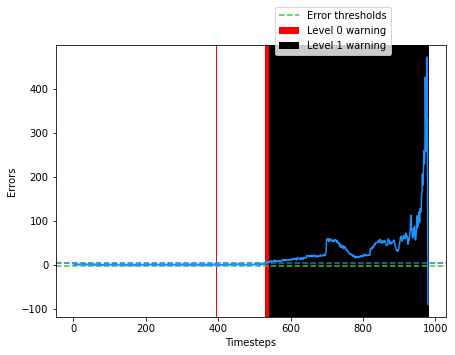

In [55]:
# The errors from the healthy portion are normally distributed
anomaly(normal_errors_std_pca,errors_std_pca,[True],['Principal Component 1'],1,1,12,0.01,1,1,figsize=(7,5))

In [56]:
inner_race = bearings[0][:,12].reshape(-1,1)
outer_race = bearings[0][:,13].reshape(-1,1)

## Outer race defect in bearing 1

### Building LSTM model for outer race defect
3 timesteps are taken as input and the immediate next timestep is the output.

In [57]:
or_scaler,X_train_or, X_test_or, y_train_or, y_test_or = prepare_data(outer_race[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_or,hist_or = build_model(X_train_or,y_train_or,timesteps=3,lstm1_units=90,batch_size=20,epochs=100,learning_rate=0.01,verbose=1)

In [58]:
# model_or.save('model_or0',save_format='h5')

In [59]:
model_or = tf.keras.models.load_model('model_or0')

In [60]:
print(f'Loss on test data: {model_or.evaluate(X_test_or,y_test_or)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0374
Loss on test data: 0.03743847832083702


### Plot predicted vs actual values

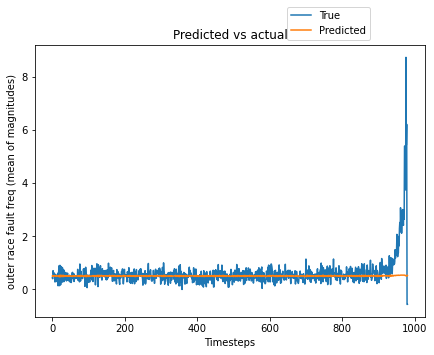

In [61]:
plot_pred_and_actual(outer_race,model_or,or_scaler,3,['outer race fault freq (mean of magnitudes)'],num_rows=1,num_cols=1,figsize=(7,5))

### Calculate errors
errors_std_or are the standardised errors of the entire data.<br> normal_errors_std_or are the standardised errors from the healthy part

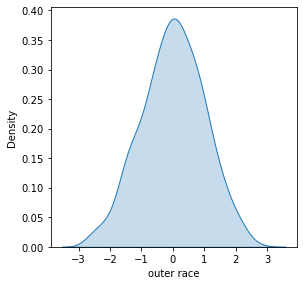

In [62]:
errors_std_or,normal_errors_std_or = calc_errors(outer_race,model_or,or_scaler,timesteps= 3,features= ['outer race'],healthy_data_len=500)

### Checking for normality using KS Test and QQ Plot

p-value for errors of feature outer_race: 0.8487192308343068
Do not reject null hypothesis (The distribution of RV is normal)

outer_race


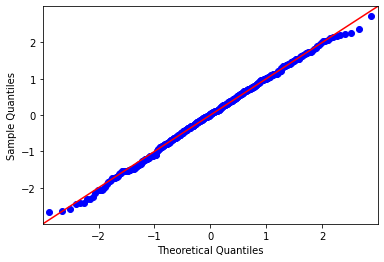

In [63]:
KStest(normal_errors_std_or,['outer_race'])
QQPlot(normal_errors_std_or,['outer_race'])

### Detecting outer race defect
If the no. of times the errors cross the upper/lower bounds in our time window(here of length = 1) is greater than or equal to level0_thresh(here,1), we increment a counter. As soon as the counter crosses the level1_thresh, we trigger an alarm for outer race defect.

Level 0 warning given at 700th timestep
Level 0 warning dies at 701th timestep
Level 0 warning given at 776th timestep
Level 0 warning dies at 777th timestep
Level 0 warning given at 878th timestep
Level 0 warning dies at 879th timestep
Level 0 warning given at 909th timestep
Level 0 warning dies at 910th timestep
Level 0 warning given at 930th timestep
Level 0 warning dies at 931th timestep
Level 0 warning given at 934th timestep
Level 0 warning dies at 935th timestep
Level 0 warning given at 937th timestep
Level 0 warning dies at 938th timestep
Level 0 warning given at 941th timestep
Level 0 warning dies at 942th timestep
Level 0 warning given at 943th timestep
Level 0 warning dies at 944th timestep
Level 0 warning given at 946th timestep
At 958th time window outer race defect is detected


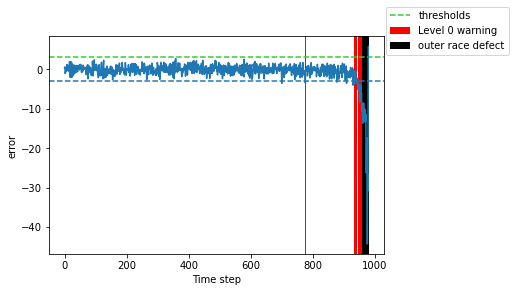

In [64]:
outer_race_defect(normal_errors_std_or,errors_std_or,is_normal=True,timewindow_len=1,level0_thresh=1,level1_thresh=12,min_delta=0,verbose=1)

### Building LSTM model for inner race defect
3 timesteps are taken as input and the immediate next timestep is the output.

In [65]:
ir_scaler,X_train_ir, X_test_ir, y_train_ir, y_test_ir = prepare_data(inner_race[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_ir,hist_ir = build_model(X_train_ir,y_train_ir,timesteps=3,lstm1_units=90,batch_size=20,epochs=100,learning_rate=0.01,verbose=1)

In [66]:
# model_ir.save('model_ir0',save_format='h5')

In [67]:
model_ir = tf.keras.models.load_model('model_ir0')

In [68]:
print(f'Loss on test data: {model_ir.evaluate(X_test_ir,y_test_ir)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0330
Loss on test data: 0.033037345856428146


### Plot predicted vs actual values

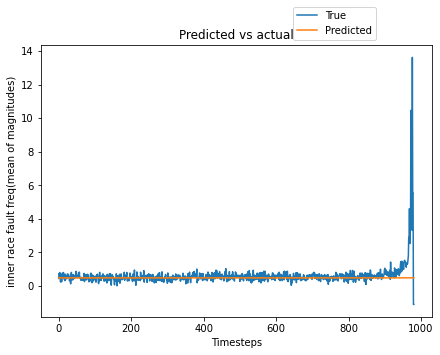

In [69]:
plot_pred_and_actual(inner_race,model_ir,ir_scaler,3,['inner race fault freq(mean of magnitudes)'],num_rows=1,num_cols=1,figsize=(7,5))

### Calculate errors
errors_std_ir are the standardised errors of the entire data.<br> normal_errors_std_ir are the standardised errors from the healthy part

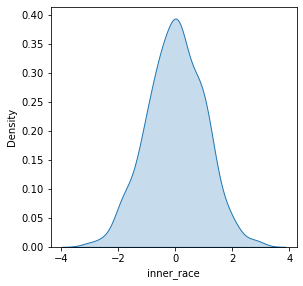

In [70]:
errors_std_ir,normal_errors_std_ir = calc_errors(inner_race,model_ir,ir_scaler,3,['inner_race'],500)

### Checking for normality using KS Test and QQ Plot

p-value for errors of feature inner_race: 0.7886527741320665
Do not reject null hypothesis (The distribution of RV is normal)

inner_race


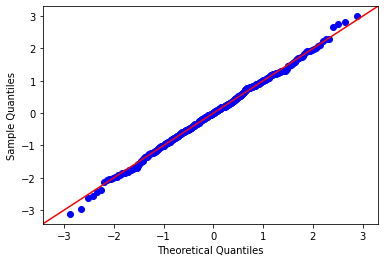

In [71]:
KStest(normal_errors_std_ir,['inner_race'])
QQPlot(normal_errors_std_ir,['inner_race'])

### Detecting outer race defect
If the no. of times the errors cross the upper/lower bounds in our time window(here of length = 1) is greater than or equal to level0_thresh(here,1), we increment a counter. As soon as the counter crosses the level1_thresh, we trigger an alarm for inner race defect.

Level 0 warning given at 461th timestep
Level 0 warning dies at 462th timestep
Level 0 warning given at 900th timestep
Level 0 warning dies at 901th timestep
Level 0 warning given at 916th timestep
Level 0 warning dies at 917th timestep
Level 0 warning given at 927th timestep
Level 0 warning dies at 928th timestep
Level 0 warning given at 937th timestep
Level 0 warning dies at 938th timestep
Level 0 warning given at 943th timestep
Level 0 warning dies at 946th timestep
Level 0 warning given at 947th timestep
Level 0 warning dies at 948th timestep
Level 0 warning given at 949th timestep
Level 0 warning dies at 952th timestep
Level 0 warning given at 953th timestep
At 967th time window inner race defect is detected


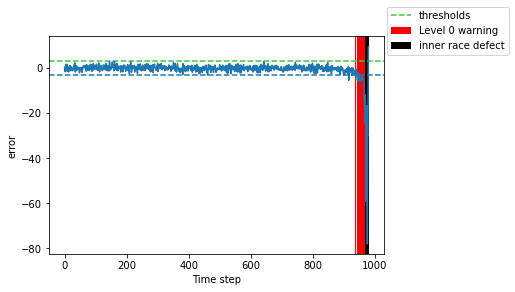

In [72]:
inner_race_defect(normal_errors_std_ir,errors_std_ir,True,1,level0_thresh=1,level1_thresh=14,min_delta=0,verbose=1)

# Bearing 2
Using 3 as input timesteps and predicting the immediate next timestep. We build an LSTM model using the healthy portion ,ie. uptil 500, use 20% of it as test set and minmax scaling is used.

In [73]:
scaler1,X_train1, X_test1, y_train1, y_test1 = prepare_data(bearings1[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model1,hist1 = build_model(X_train1,y_train1,timesteps=3,lstm1_units=80,batch_size=20,epochs=100,learning_rate=0.01,verbose=1)

In [74]:
# model1.save('model1',save_format='h5')

In [75]:
model1 = tf.keras.models.load_model('model1')

In [76]:
print(f'Loss on test data: {model1.evaluate(X_test1,y_test1)}')

4/4 [==============================] - 0s 4ms/step - loss: 0.0217
Loss on test data: 0.021688425913453102


### Plot predicted vs actual values

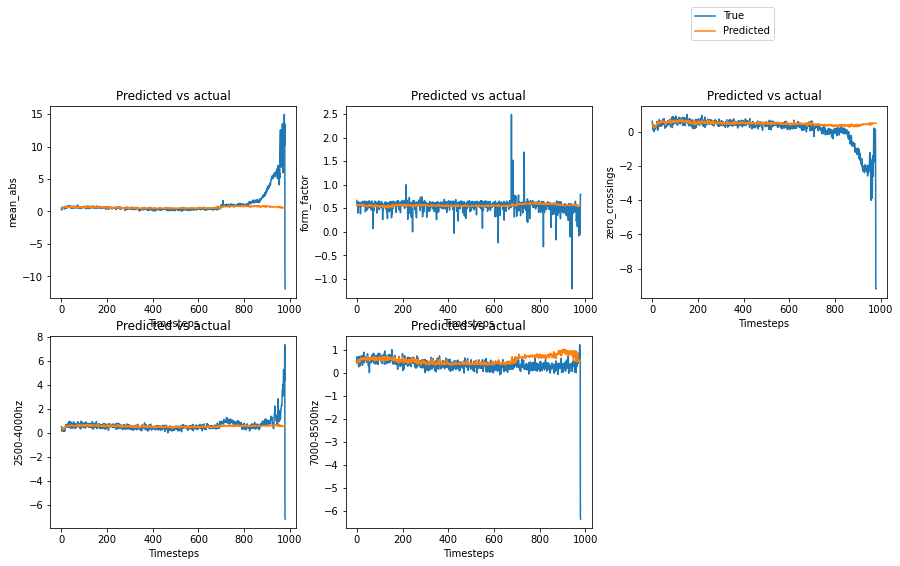

In [77]:
plot_pred_and_actual(bearings1,model1,scaler1,3,features_names_selected)

### Calculate errors
errors_std1 are the standardised errors of the entire data.<br> normal_errors_std1 are the standardised errors from the healthy part

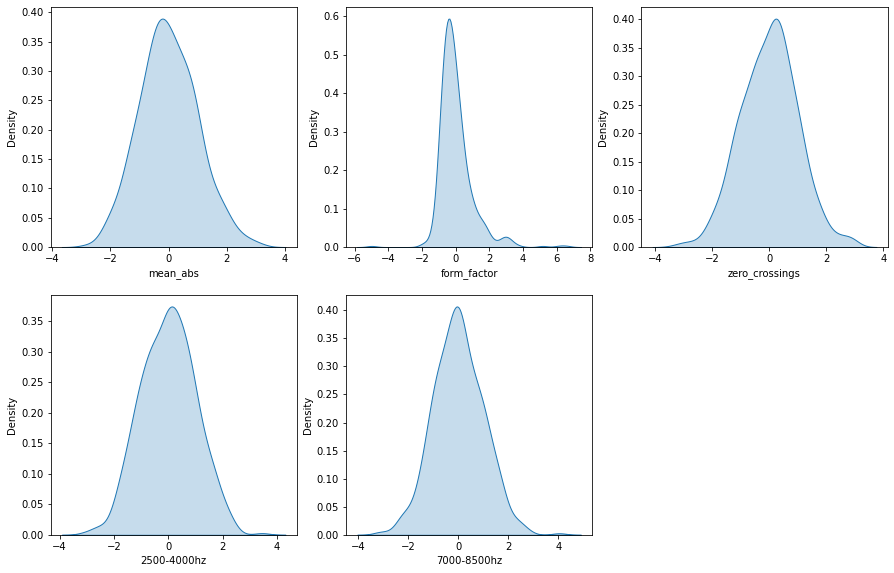

In [78]:
errors_std1,normal_errors_std1 = calc_errors(bearings1,model1,scaler1,3,features_names_selected,500)

### Checking for normality using KS Test and QQ Plot

In [79]:
KStest(normal_errors_std1,features_names_selected)

p-value for errors of feature mean_abs: 0.7502508010318513
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature form_factor: 2.6575922337153988e-08
Reject the null hypothesis (RV doesnt follow a normal distribution)

p-value for errors of feature zero_crossings: 0.801572756601341
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature 2500-4000hz: 0.9310404525848949
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature 7000-8500hz: 0.35885032622509183
Do not reject null hypothesis (The distribution of RV is normal)



mean_abs


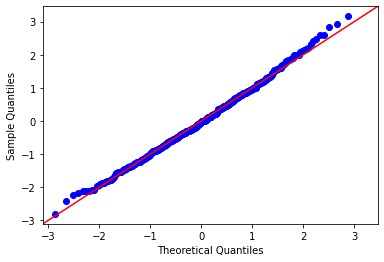

form_factor


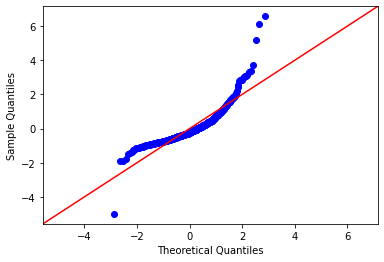

zero_crossings


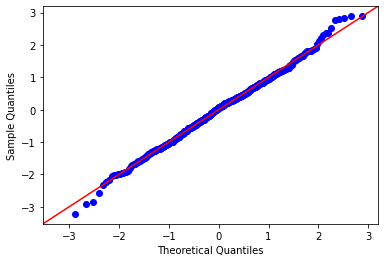

2500-4000hz


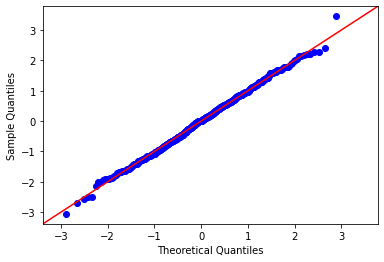

7000-8500hz


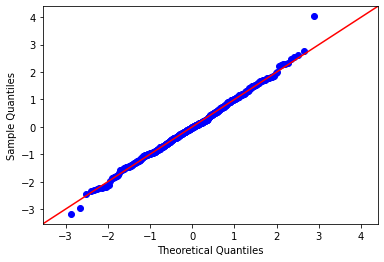

In [80]:
QQPlot(normal_errors_std1,features_names_selected)

### Detecting anomaly
A level 0 warning is triggered and a counter is incremented whenever the errors cross the thresholds for 1 timestep in the entire time window of given length(here, 1). If the level 0 counter crosses the level1 threshold(here,12) a level 1 warning is triggered. Therefore, an anomaly is detected if we get a level 0 warning for continuously 2 hours.

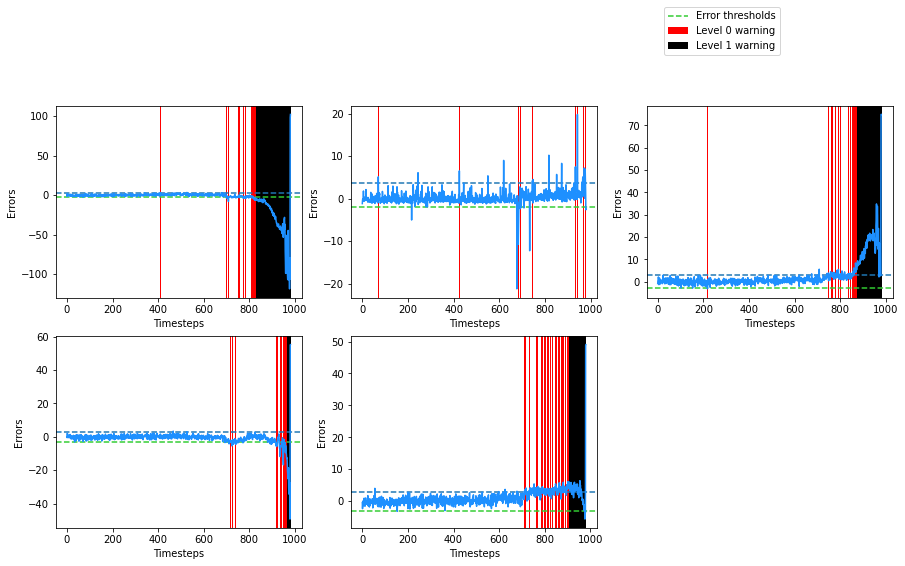

In [81]:
normal_dist_erros = [True,False,True,True,True]
anomaly(normal_errors_std1,errors_std1,normal_dist_errors,features_names_selected,1,1,12,min_delta=0,verbose=0)

## Combining features
We apply PCA and keep the first principal component(which has the maximal importance(variance)). The first PC is used to build a model and make predictions.

In [82]:
bearings1_pca = firstPrincipalComponent(bearings1,healthy_data_len=500,test_size=0.2,scaling_technique='minmax')

In [83]:
# Build the model
scaler_pca1,X_train_pca1, X_test_pca1, y_train_pca1, y_test_pca1 = prepare_data(bearings1_pca[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_pca1,hist_pca1 = build_model(X_train_pca1,y_train_pca1,timesteps=3,lstm1_units=80,batch_size=20,epochs=100,learning_rate=0.01,verbose=1)

In [84]:
# model_pca1.save('model_pca1',save_format='h5')

In [85]:
model_pca1 = tf.keras.models.load_model('model_pca1')

In [86]:
model_pca1.evaluate(X_test_pca1,y_test_pca1)

4/4 [==============================] - 0s 3ms/step - loss: 0.0275


0.027497997507452965

### Plot predicted vs actual

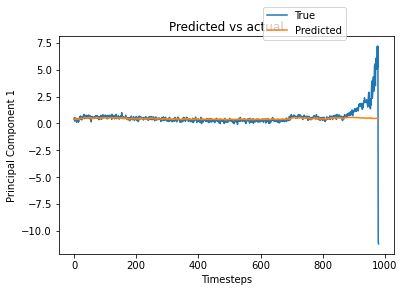

In [87]:
plot_pred_and_actual(bearings1_pca,model_pca1,scaler_pca1,3,['Principal Component 1'],num_rows=1,num_cols=1,figsize=(6,4))

### Calculate errors

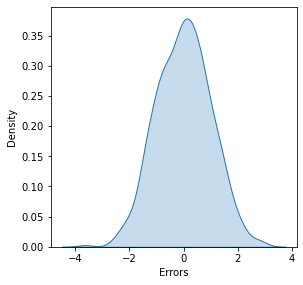

In [88]:
errors_std_pca1,normal_errors_std_pca1 = calc_errors(bearings1_pca,model_pca1,scaler_pca1,3,['Errors'],500)

### Checking for normality

p-value for errors of feature PC_1: 0.7122958886276718
Do not reject null hypothesis (The distribution of RV is normal)

Principal Component 1


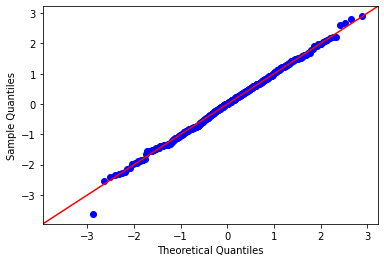

In [89]:
KStest(normal_errors_std_pca1,['PC_1'])
QQPlot(normal_errors_std_pca1,['Principal Component 1'])

### Detecting anomaly

Level 0 warning given at 153th timestep
Level 0 warning dies at 154th timestep
Level 0 warning given at 526th timestep
Level 0 warning dies at 527th timestep
Level 0 warning given at 884th timestep
Level 0 warning dies at 885th timestep
Level 0 warning given at 890th timestep
Level 0 warning dies at 891th timestep
Level 0 warning given at 892th timestep
Level 0 warning dies at 896th timestep
Level 0 warning given at 898th timestep
Level 1 warning given at 910th timestep


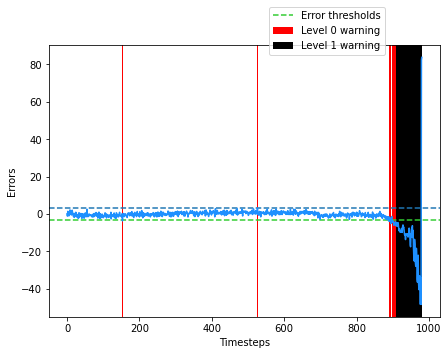

In [90]:
anomaly(normal_errors_std_pca1,errors_std_pca1,[True],['PC_1'],1,1,12,min_delta=0,num_rows=1,num_cols=1,figsize=(7,5))

In [91]:
inner_race1 = bearings[1][:,12].reshape(-1,1)
outer_race1 = bearings[1][:,13].reshape(-1,1)

### Checking for Outer race defect in bearing 2

In [92]:
or_scaler1,X_train_or1, X_test_or1, y_train_or1, y_test_or1 = prepare_data(outer_race1[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_or1,hist_or1 = build_model(X_train_or1,y_train_or1,timesteps=3,lstm1_units=80,batch_size=20,epochs=100,learning_rate=0.01,verbose=1)

In [93]:
# model_or1.save('model_or1',save_format='h5')

In [94]:
model_or1 = tf.keras.models.load_model('model_or1')

In [95]:
print(f'Loss on test data: {model_or1.evaluate(X_test_or1,y_test_or1)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0260
Loss on test data: 0.026017215102910995


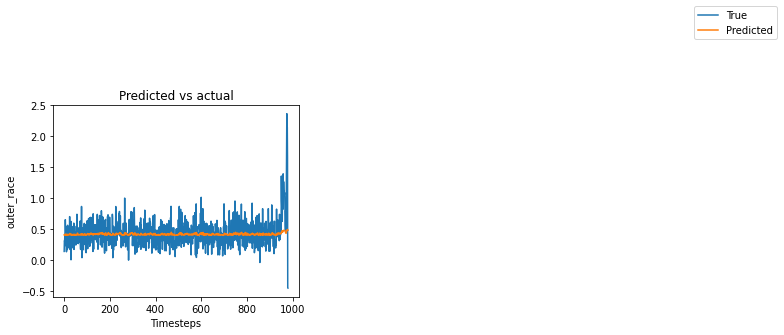

In [96]:
plot_pred_and_actual(outer_race1,model_or1,or_scaler1,3,['outer_race'])

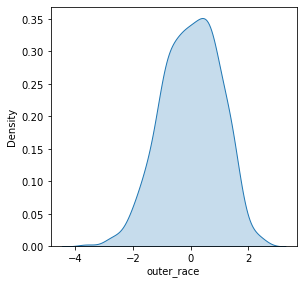

In [97]:
errors_std_or1,normal_errors_std_or1 = calc_errors(outer_race1,model_or1,or_scaler1,3,['outer_race'],500)

### Checking for normality of errors

p-value for errors of feature outer_race: 0.2844721818296879
Do not reject null hypothesis (The distribution of RV is normal)

outer_race


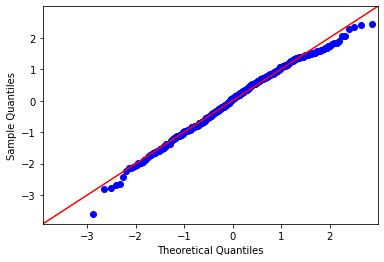

In [98]:
KStest(normal_errors_std_or1,['outer_race'])
QQPlot(normal_errors_std_or1,['outer_race'])

### Detecting outer race defect

Level 0 warning given at 265th timestep
Level 0 warning dies at 266th timestep
Level 0 warning given at 600th timestep
Level 0 warning dies at 601th timestep
Level 0 warning given at 700th timestep
Level 0 warning dies at 701th timestep
Level 0 warning given at 748th timestep
Level 0 warning dies at 749th timestep
Level 0 warning given at 823th timestep
Level 0 warning dies at 824th timestep
Level 0 warning given at 951th timestep
Level 0 warning dies at 953th timestep
Level 0 warning given at 956th timestep
Level 0 warning dies at 957th timestep
Level 0 warning given at 958th timestep
Level 0 warning dies at 967th timestep
Level 0 warning given at 973th timestep


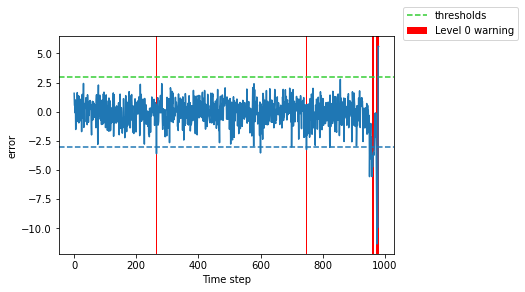

In [99]:
# No outer race is detected
outer_race_defect(normal_errors_std_or1,errors_std_or1,True,1,1,12,min_delta=0,verbose=1)

### Checking for inner race defect in bearing 2

In [100]:
ir_scaler1,X_train_ir1, X_test_ir1, y_train_ir1, y_test_ir1 = prepare_data(inner_race1[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_ir1,hist_ir1 = build_model(X_train_ir1,y_train_ir1,timesteps=3,lstm1_units=90,batch_size=20,epochs=100,learning_rate=0.01,verbose=1)

In [101]:
# model_ir1.save('model_ir1',save_format='h5')

In [102]:
model_ir1 = tf.keras.models.load_model('model_ir1')

In [103]:
print(f'Loss on test data: {model_ir1.evaluate(X_test_ir1,y_test_ir1)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0198
Loss on test data: 0.019791480153799057


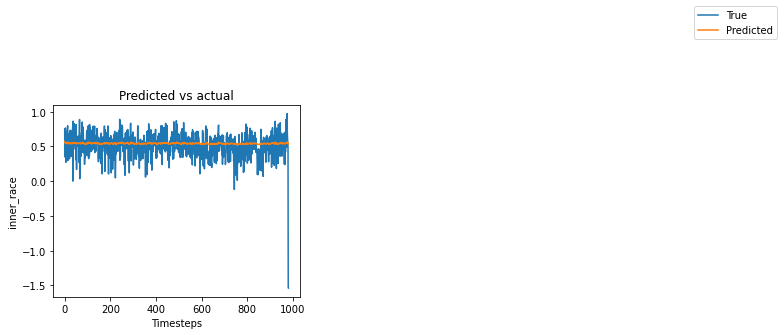

In [104]:
plot_pred_and_actual(inner_race1,model_ir1,ir_scaler1,3,['inner_race'])

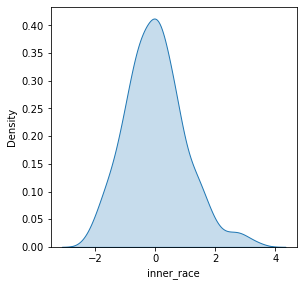

In [105]:
errors_std_ir1,normal_errors_std_ir1 = calc_errors(inner_race1,model_ir1,ir_scaler1,3,['inner_race'],500)

p-value for errors of feature inner_race: 0.2548661296193455
Do not reject null hypothesis (The distribution of RV is normal)

inner_race


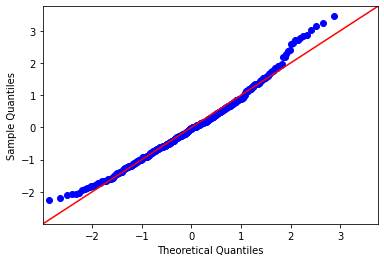

In [106]:
KStest(normal_errors_std_ir1,['inner_race'])
QQPlot(normal_errors_std_ir1,['inner_race'])

### Detecting inner race defect

Level 0 warning given at 36th timestep
Level 0 warning dies at 37th timestep
Level 0 warning given at 66th timestep
Level 0 warning dies at 67th timestep
Level 0 warning given at 222th timestep
Level 0 warning dies at 223th timestep
Level 0 warning given at 354th timestep
Level 0 warning dies at 355th timestep
Level 0 warning given at 743th timestep
Level 0 warning dies at 744th timestep
Level 0 warning given at 756th timestep
Level 0 warning dies at 757th timestep
Level 0 warning given at 869th timestep
Level 0 warning dies at 870th timestep
Level 0 warning given at 969th timestep
Level 0 warning dies at 970th timestep
Level 0 warning given at 974th timestep
Level 0 warning dies at 975th timestep
Level 0 warning given at 979th timestep


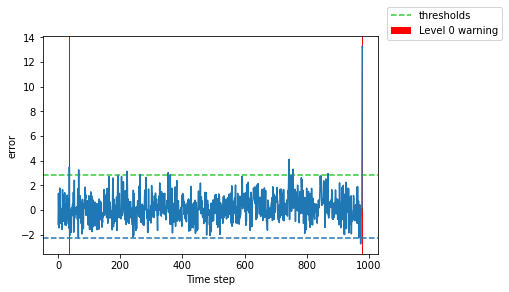

In [107]:
# Data cannot be assumed to be normal according to the QQ Plot
# No inner race defect detected
inner_race_defect(normal_errors_std_ir1,errors_std_ir1,False,1,1,12,min_delta=0,verbose=1)

# Bearing 3
Using 3 as input timesteps and predicting the immediate next timestep. We build an LSTM model using the healthy portion ,ie. uptil 500, use 20% of it as test set and minmax scaling is used.

In [108]:
scaler2,X_train2, X_test2, y_train2, y_test2 = prepare_data(bearings2[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model2,hist2 = build_model(X_train2,y_train2,timesteps=3,lstm2_units=50,lstm1_units=90,batch_size=30,epochs=100,learning_rate=0.01,verbose=1)

In [109]:
# model2.save('model2',save_format='h5')

In [110]:
model2 = tf.keras.models.load_model('model2')

In [111]:
print(f'Loss on test data: {model2.evaluate(X_test2,y_test2)}')

4/4 [==============================] - 1s 3ms/step - loss: 0.0115
Loss on test data: 0.011498545296490192


### Plot predicted vs actual values for all features

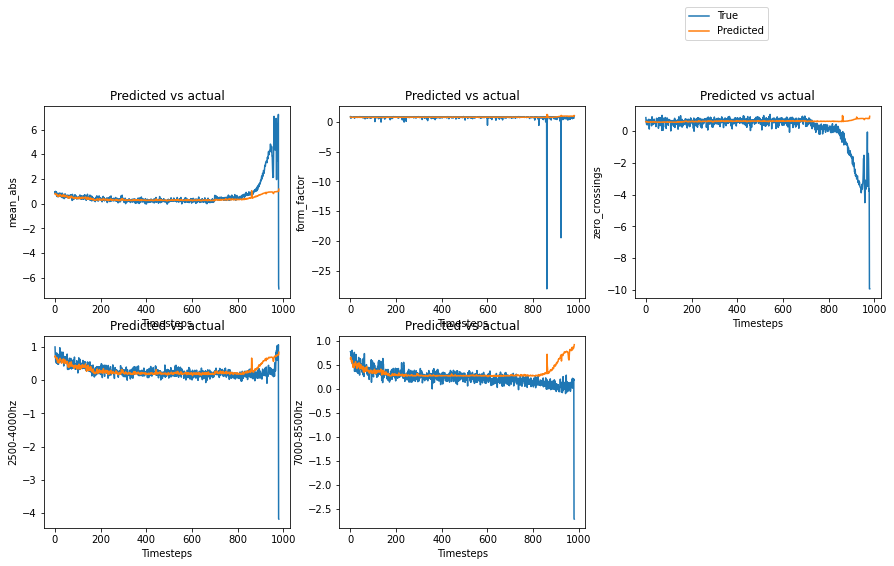

In [112]:
plot_pred_and_actual(bearings2,model2,scaler2,3,features_names_selected)

### Calculate errors
errors_std2 are the standardised errors of the entire data.<br> normal_errors_std2 are the standardised errors from the healthy part

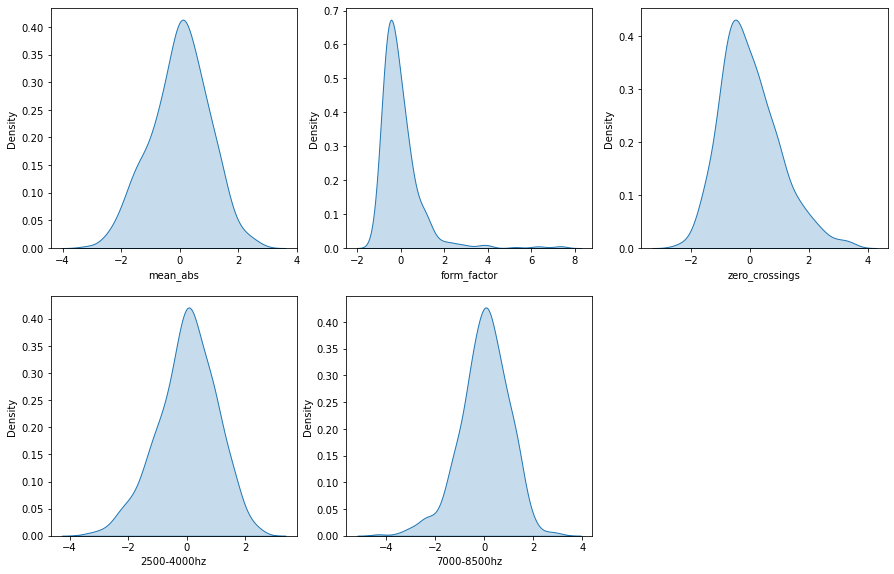

In [113]:
errors_std2,normal_errors_std2 = calc_errors(bearings2,model2,scaler2,3,features_names_selected,500)

### Checking for normality

In [114]:
KStest(normal_errors_std2,features_names_selected)

p-value for errors of feature mean_abs: 0.2194187518124926
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature form_factor: 7.555391639617766e-13
Reject the null hypothesis (RV doesnt follow a normal distribution)

p-value for errors of feature zero_crossings: 0.006278328161142685
Reject the null hypothesis (RV doesnt follow a normal distribution)

p-value for errors of feature 2500-4000hz: 0.24742969635527312
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature 7000-8500hz: 0.24173094633674597
Do not reject null hypothesis (The distribution of RV is normal)



mean_abs


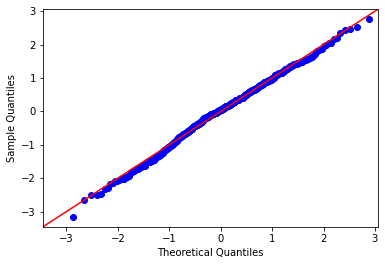

form_factor


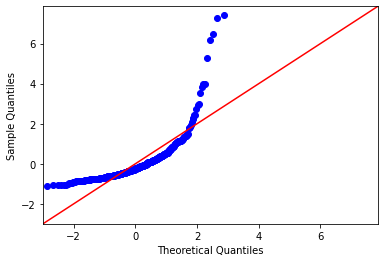

zero_crossings


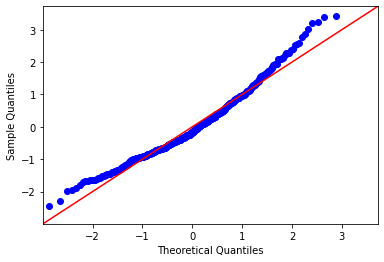

2500-4000hz


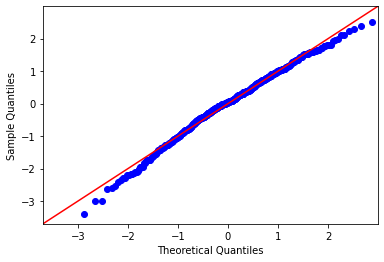

7000-8500hz


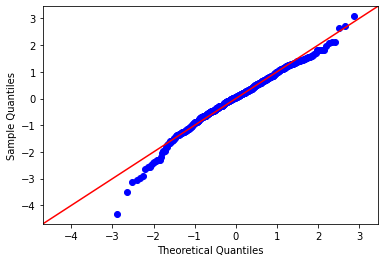

In [115]:
QQPlot(normal_errors_std2,features_names_selected)

### Detecting anomaly
A level 0 warning is triggered and a counter is incremented whenever the errors cross the thresholds for 1 timestep in the entire time window of given length(here, 1). If the level 0 counter crosses the level1 threshold(here,12) a level 1 warning is triggered. Therefore, an anomaly is detected if we get a level 0 warning for continuously 2 hours.

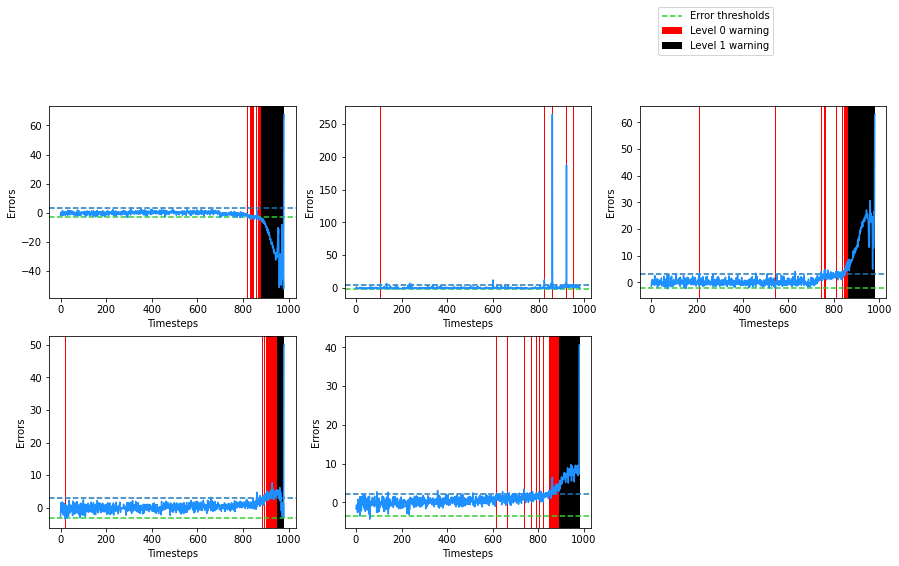

In [116]:
normal_dist_errors = [True,False,False,True,False]
anomaly(normal_errors_std2,errors_std2,normal_dist_errors,features_names_selected,1,1,12,min_delta=0,verbose=0)

### Combining features using PCA

In [117]:
bearings2_pca = firstPrincipalComponent(bearings2,healthy_data_len=500,test_size=0.2,scaling_technique='minmax')

In [118]:
scaler_pca2,X_train_pca2, X_test_pca2, y_train_pca2, y_test_pca2 = prepare_data(bearings2_pca[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_pca2,hist_pca2 = build_model(X_train_pca2,y_train_pca2,timesteps=3,lstm1_units=80,batch_size=20,epochs=100,learning_rate=0.01,verbose=1)

In [119]:
# model_pca2.save('model_pca2',save_format='h5')

In [120]:
model_pca2 = tf.keras.models.load_model('model_pca2')

In [121]:
print(f'Loss on test data: {model_pca2.evaluate(X_test_pca2,y_test_pca2)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0086
Loss on test data: 0.008593027479946613


### Plot predicted vs actual

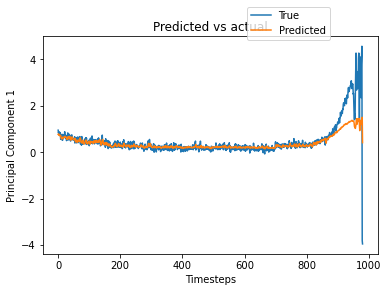

In [122]:
plot_pred_and_actual(bearings2_pca,model_pca2,scaler_pca2,3,['Principal Component 1'],num_rows=1,num_cols=1,figsize=(6,4))

### Calculate errors

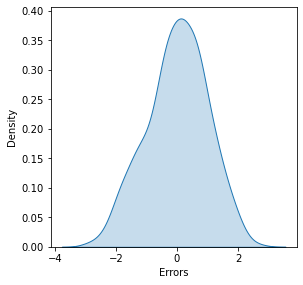

In [123]:
errors_std_pca2,normal_errors_std_pca2 = calc_errors(bearings2_pca,model_pca2,scaler_pca2,3,['Errors'],500)

### Checking for normality

p-value for errors of feature PC_1: 0.554806467139783
Do not reject null hypothesis (The distribution of RV is normal)

Principal Component 1


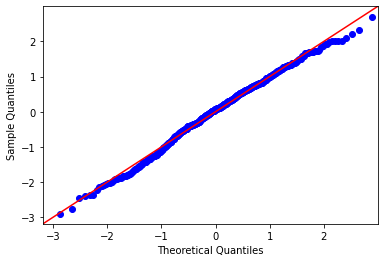

In [124]:
KStest(normal_errors_std_pca2,['PC_1'])
QQPlot(normal_errors_std_pca2,['Principal Component 1'])

### Detecting anomaly

Level 0 warning given at 889th timestep
Level 0 warning dies at 890th timestep
Level 0 warning given at 893th timestep
Level 0 warning dies at 894th timestep
Level 0 warning given at 898th timestep
Level 0 warning dies at 901th timestep
Level 0 warning given at 903th timestep
Level 0 warning dies at 906th timestep
Level 0 warning given at 907th timestep
Level 1 warning given at 919th timestep


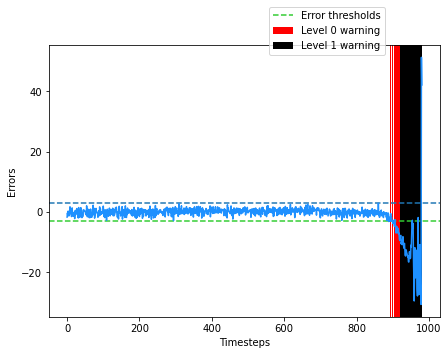

In [125]:
anomaly(normal_errors_std_pca2,errors_std_pca2,[True],['PC_1'],1,1,12,min_delta=0,num_rows=1,num_cols=1,figsize=(7,5))

In [126]:
inner_race2 = bearings[2][:,12].reshape(-1,1)
outer_race2 = bearings[2][:,13].reshape(-1,1)

### Checking for outer race defect in Bearing 3

In [127]:
or_scaler2,X_train_or2, X_test_or2, y_train_or2, y_test_or2 = prepare_data(outer_race2[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_or2,hist_or2 = build_model(X_train_or2,y_train_or2,timesteps=3,lstm2_units=50,lstm1_units=80,batch_size=20,epochs=100,learning_rate=0.01,verbose=1)

In [128]:
# model_or2.save('model_or2',save_format='h5')

In [129]:
model_or2 = tf.keras.models.load_model('model_or2')

In [130]:
print(f'Loss on test data: {model_or2.evaluate(X_test_or2,y_test_or2)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0324
Loss on test data: 0.032388459891080856


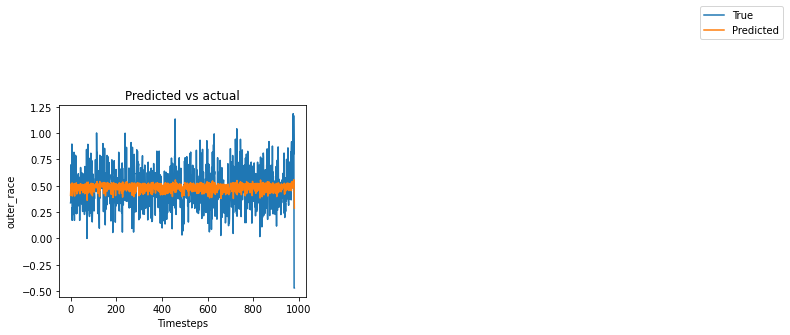

In [131]:
plot_pred_and_actual(outer_race2,model_or2,or_scaler2,3,['outer_race'])

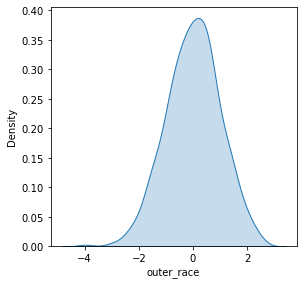

In [132]:
errors_std_or2,normal_errors_std_or2 = calc_errors(outer_race2,model_or2,or_scaler2,3,['outer_race'],500)

p-value for errors of feature outer_race: 0.979018712006602
Do not reject null hypothesis (The distribution of RV is normal)

outer_race


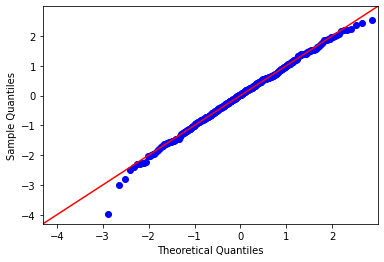

In [133]:
KStest(normal_errors_std_or2,['outer_race'])
QQPlot(normal_errors_std_or2,['outer_race'])

### Detecting outer race defect
The errors can be assumed to be normally distributed. No outer race is detected.

Level 0 warning given at 458th timestep
Level 0 warning dies at 459th timestep
Level 0 warning given at 728th timestep
Level 0 warning dies at 729th timestep
Level 0 warning given at 975th timestep
Level 0 warning dies at 976th timestep
Level 0 warning given at 977th timestep
Level 0 warning dies at 978th timestep
Level 0 warning given at 979th timestep


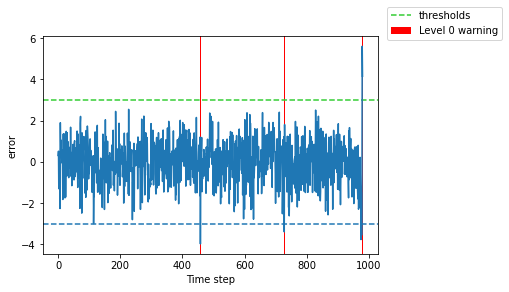

In [134]:
outer_race_defect(normal_errors_std_or2,errors_std_or2,True,1,1,12,min_delta=0,verbose=1)

### Checking for inner race defect in Bearing 3

In [135]:
ir_scaler2,X_train_ir2, X_test_ir2, y_train_ir2, y_test_ir2 = prepare_data(inner_race2[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_ir2,hist_ir2 = build_model(X_train_ir2,y_train_ir2,timesteps=3,lstm2_units=50,lstm1_units=90,batch_size=30,epochs=100,learning_rate=0.01,verbose=1)

In [136]:
# model_ir2.save('model_ir2',save_format='h5')

In [137]:
model_ir2 = tf.keras.models.load_model('model_ir2')

In [138]:
print(f'Loss on test data: {model_ir2.evaluate(X_test_ir2,y_test_ir2)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0204
Loss on test data: 0.020367572084069252


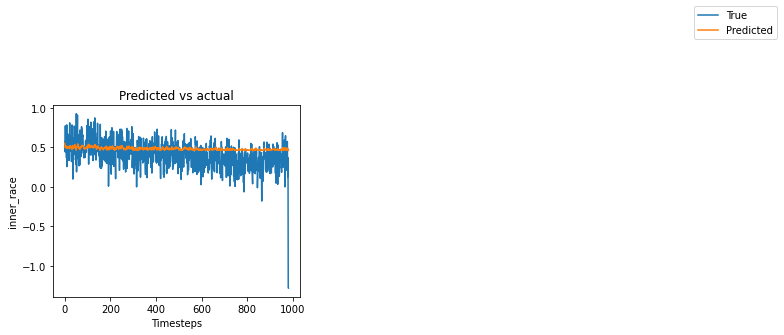

In [139]:
plot_pred_and_actual(inner_race2,model_ir2,ir_scaler2,3,['inner_race'])

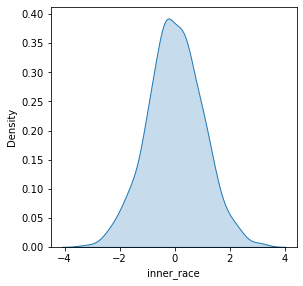

In [140]:
errors_std_ir2,normal_errors_std_ir2 = calc_errors(inner_race2,model_ir2,ir_scaler2,3,['inner_race'],500)

p-value for errors of feature inner_race: 0.8832102963459487
Do not reject null hypothesis (The distribution of RV is normal)

inner_race


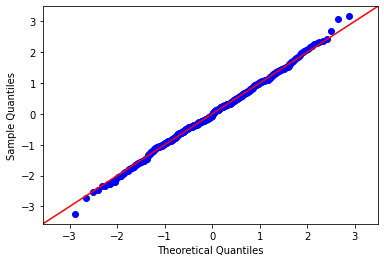

In [141]:
KStest(normal_errors_std_ir2,['inner_race'])
QQPlot(normal_errors_std_ir2,['inner_race'])

### Detecting inner race defect
From the graph, we can see that no inner race defect is detected.

Level 0 warning given at 51th timestep
Level 0 warning dies at 52th timestep
Level 0 warning given at 192th timestep
Level 0 warning dies at 193th timestep
Level 0 warning given at 315th timestep
Level 0 warning dies at 316th timestep
Level 0 warning given at 723th timestep
Level 0 warning dies at 724th timestep
Level 0 warning given at 746th timestep
Level 0 warning dies at 747th timestep
Level 0 warning given at 785th timestep
Level 0 warning dies at 786th timestep
Level 0 warning given at 844th timestep
Level 0 warning dies at 845th timestep
Level 0 warning given at 863th timestep
Level 0 warning dies at 864th timestep
Level 0 warning given at 964th timestep
Level 0 warning dies at 965th timestep
Level 0 warning given at 979th timestep


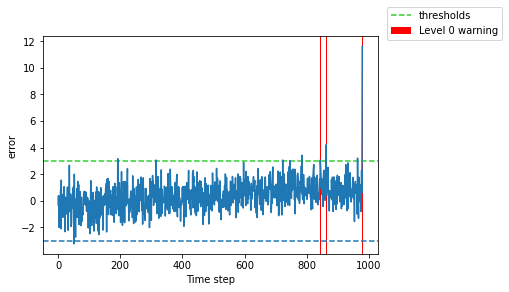

In [142]:
inner_race_defect(normal_errors_std_ir2,errors_std_ir2,True,1,1,12,min_delta=0,verbose=1)

# Bearing 4
Using 3 as input timesteps and predicting the immediate next timestep. We build an LSTM model using the healthy portion ,ie. uptil 500, use 20% of it as test set and minmax scaling is used.

In [143]:
scaler3,X_train3, X_test3, y_train3, y_test3 = prepare_data(bearings3[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model3,hist3 = build_model(X_train3,y_train3,timesteps=3,lstm2_units=50,lstm1_units=80,batch_size=30,epochs=100,learning_rate=0.01,verbose=1)

In [144]:
# model3.save('model3',save_format='h5')

In [145]:
model3 = tf.keras.models.load_model('model3')

In [146]:
print(f'Loss on test data: {model3.evaluate(X_test3,y_test3)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0256
Loss on test data: 0.0255716722458601


### Plot predicted and actual values for all features

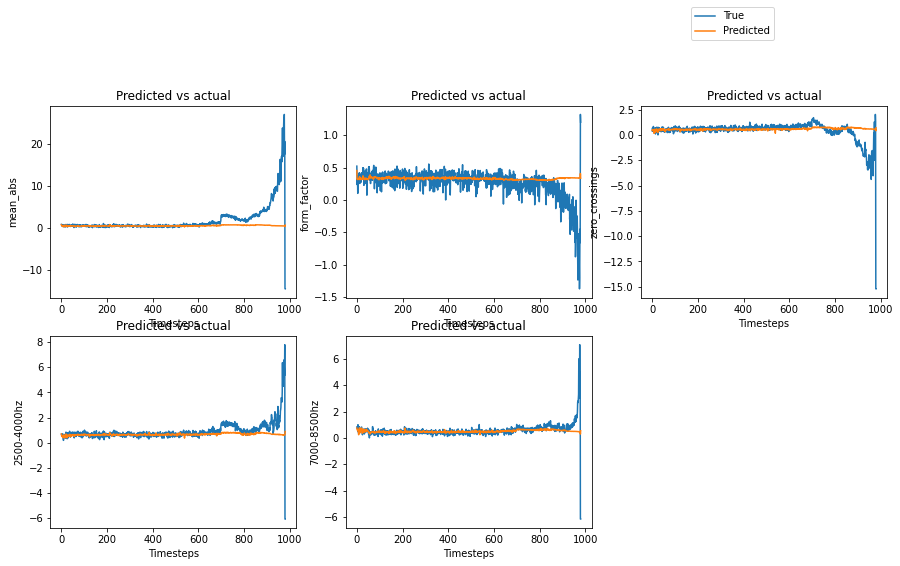

In [147]:
plot_pred_and_actual(bearings3,model3,scaler3,3,features_names_selected)

### Calculate errors
errors_std3 are the standardised errors of the entire data.<br> normal_errors_std3 are the standardised errors from the healthy part

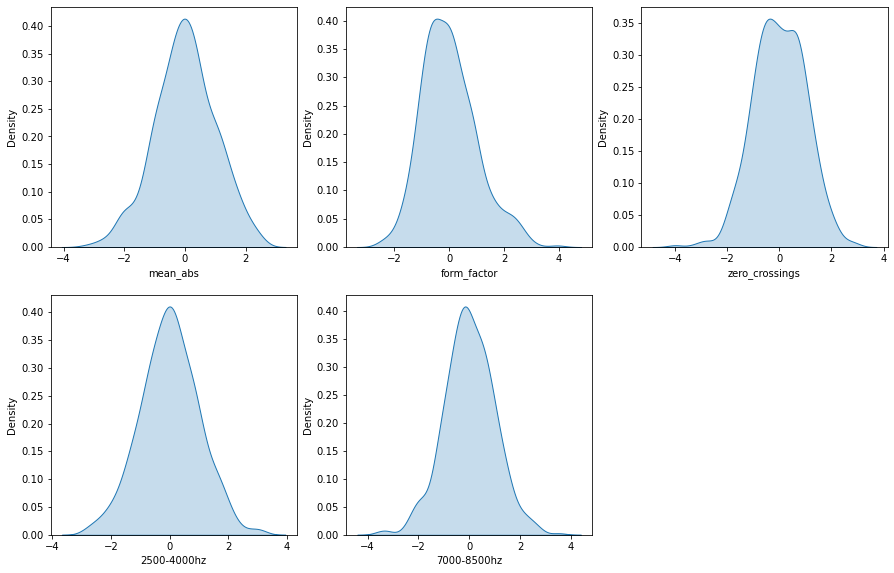

In [148]:
errors_std3,normal_errors_std3 = calc_errors(bearings3,model3,scaler3,3,features_names_selected,500)

### Checking for normality using KS Test and QQ Plot

In [149]:
KStest(normal_errors_std3,features_names_selected)

p-value for errors of feature mean_abs: 0.8106273754664542
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature form_factor: 0.09192303508816024
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature zero_crossings: 0.36740184110609064
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature 2500-4000hz: 0.9224853941293021
Do not reject null hypothesis (The distribution of RV is normal)

p-value for errors of feature 7000-8500hz: 0.8595341945737885
Do not reject null hypothesis (The distribution of RV is normal)



mean_abs


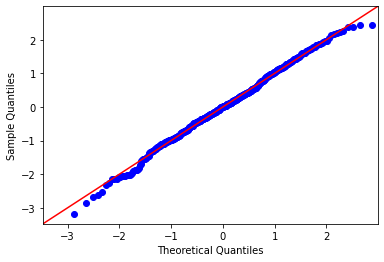

form_factor


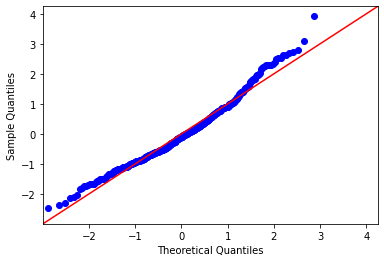

zero_crossings


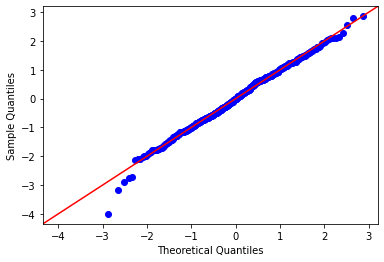

2500-4000hz


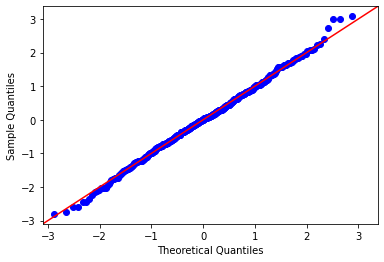

7000-8500hz


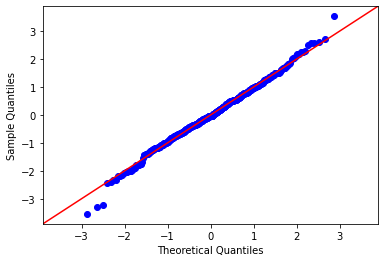

In [150]:
QQPlot(normal_errors_std3,features_names_selected)

### Detecting anomaly

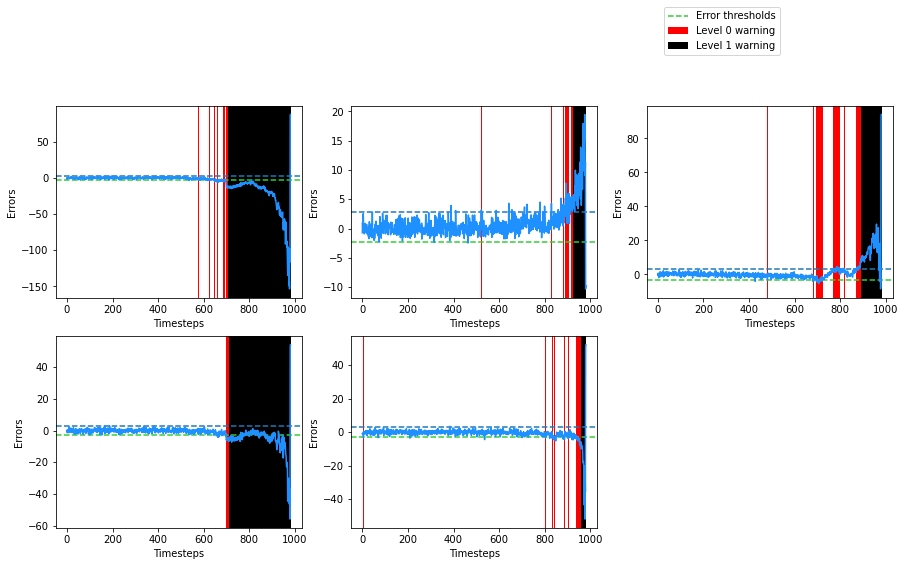

In [151]:
normal_dist_errors = [True,False,True,True,True]
anomaly(normal_errors_std3,errors_std3,normal_dist_errors,features_names_selected,1,1,12,min_delta=0,verbose=0)

## Combining features using PCA

In [152]:
bearings3_pca = firstPrincipalComponent(bearings3,healthy_data_len=500,test_size=0.2,scaling_technique='minmax')

In [153]:
scaler_pca3,X_train_pca3, X_test_pca3, y_train_pca3, y_test_pca3 = prepare_data(bearings3_pca[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_pca3,hist_pca3 = build_model(X_train_pca3,y_train_pca3,timesteps=3,lstm1_units=80,batch_size=20,epochs=100,learning_rate=0.01,verbose=1)

In [154]:
# model_pca3.save('model_pca3',save_format='h5')

In [155]:
model_pca3 = tf.keras.models.load_model('model_pca3')

In [156]:
print(f'Loss on test data: {model_pca3.evaluate(X_test_pca3,y_test_pca3)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0258
Loss on test data: 0.025836121290922165


CPU times: user 567 ms, sys: 20.3 ms, total: 587 ms
Wall time: 524 ms


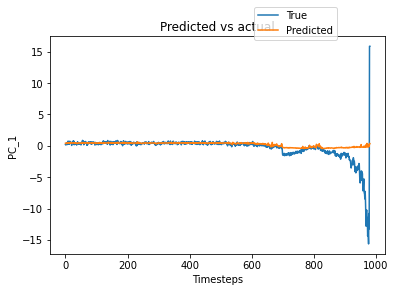

In [157]:
%%time
plot_pred_and_actual(bearings3_pca,model_pca3,scaler_pca3,3,['PC_1'],num_rows=1,num_cols=1,figsize=(6,4))

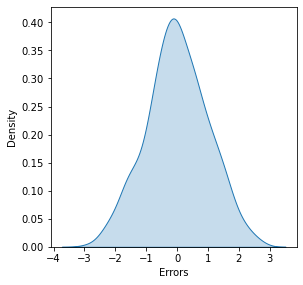

In [158]:
errors_std_pca3,normal_errors_std_pca3 = calc_errors(bearings3_pca,model_pca3,scaler_pca3,3,['Errors'],500)

p-value for errors of feature PC_1: 0.8540709152245141
Do not reject null hypothesis (The distribution of RV is normal)

Principal Component 1


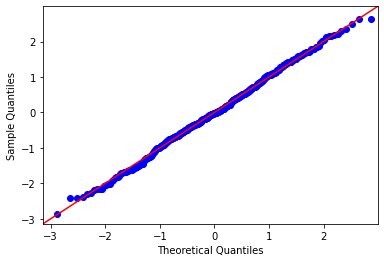

In [159]:
KStest(normal_errors_std_pca3,['PC_1'])
QQPlot(normal_errors_std_pca3,['Principal Component 1'])

Level 0 warning given at 535th timestep
Level 0 warning dies at 536th timestep
Level 0 warning given at 587th timestep
Level 0 warning dies at 588th timestep
Level 0 warning given at 653th timestep
Level 0 warning dies at 654th timestep
Level 0 warning given at 663th timestep
Level 0 warning dies at 664th timestep
Level 0 warning given at 666th timestep
Level 0 warning dies at 668th timestep
Level 0 warning given at 680th timestep
Level 0 warning dies at 681th timestep
Level 0 warning given at 696th timestep
Level 0 warning dies at 698th timestep
Level 0 warning given at 699th timestep
Level 1 warning given at 711th timestep


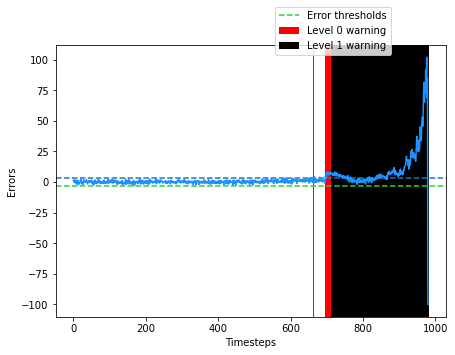

In [161]:
anomaly(normal_errors_std_pca3,errors_std_pca3,[True],['PC_1'],1,1,12,min_delta=0.0,num_rows=1,num_cols=1,figsize=(7,5))

In [162]:
inner_race3 = bearings[3][:,12].reshape(-1,1)
outer_race3 = bearings[3][:,13].reshape(-1,1)

### Checking for outer race defect in Bearing 4

In [163]:
or_scaler3,X_train_or3, X_test_or3, y_train_or3, y_test_or3 = prepare_data(outer_race3[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_or3,hist_or3 = build_model(X_train_or3,y_train_or3,timesteps=3,lstm2_units=50,lstm1_units=90,batch_size=30,epochs=100,learning_rate=0.01,verbose=1)

In [164]:
# model_or3.save('model_or3',save_format='h5')

In [165]:
model_or3 = tf.keras.models.load_model('model_or3')

In [166]:
print(f'Loss on test data: {model_or3.evaluate(X_test_or3,y_test_or3)}')

4/4 [==============================] - 0s 4ms/step - loss: 0.0338
Loss on test data: 0.03381064534187317


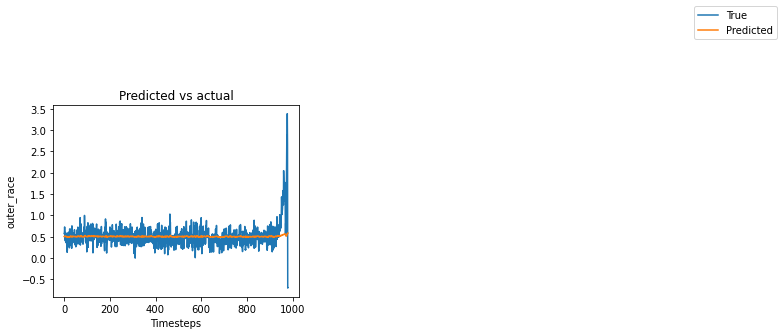

In [167]:
plot_pred_and_actual(outer_race3,model_or3,or_scaler3,3,['outer_race'])

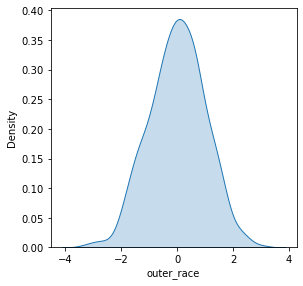

In [168]:
errors_std_or3,normal_errors_std_or3 = calc_errors(outer_race3,model_or3,or_scaler3,3,['outer_race'],500)

p-value for errors of feature outer_race: 0.8245263679798949
Do not reject null hypothesis (The distribution of RV is normal)

outer_race


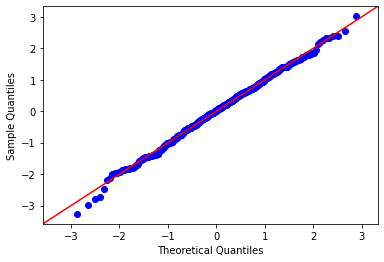

In [169]:
KStest(normal_errors_std_or3,['outer_race'])
QQPlot(normal_errors_std_or3,['outer_race'])

### Detecting outer race defect

Level 0 warning given at 311th timestep
Level 0 warning dies at 312th timestep
Level 0 warning given at 463th timestep
Level 0 warning dies at 464th timestep
Level 0 warning given at 944th timestep
Level 0 warning dies at 945th timestep
Level 0 warning given at 952th timestep
Level 0 warning dies at 954th timestep
Level 0 warning given at 955th timestep
At 967th time window outer race defect is detected


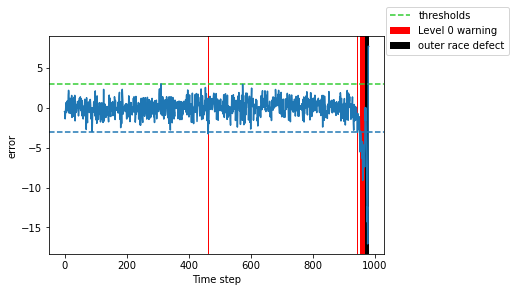

In [170]:
outer_race_defect(normal_errors_std_or3,errors_std_or3,True,1,1,12,min_delta=0,verbose=1)

### Checking for inner race defect in Bearing 4

In [171]:
ir_scaler3,X_train_ir3, X_test_ir3, y_train_ir3, y_test_ir3 = prepare_data(inner_race3[:500,:],time_steps=3,test_size=0.2,scaling_technique='minmax')

# model_ir3,hist_ir3 = build_model(X_train_ir3,y_train_ir3,timesteps=3,lstm2_units=50,lstm1_units=90,batch_size=30,epochs=100,learning_rate=0.01,verbose=1)

In [172]:
# model_ir3.save('model_ir3',save_format='h5')

In [173]:
model_ir3 = tf.keras.models.load_model('model_ir3')

In [174]:
print(f'Loss on test data: {model_ir3.evaluate(X_test_ir3,y_test_ir3)}')

4/4 [==============================] - 0s 3ms/step - loss: 0.0274
Loss on test data: 0.027393149212002754


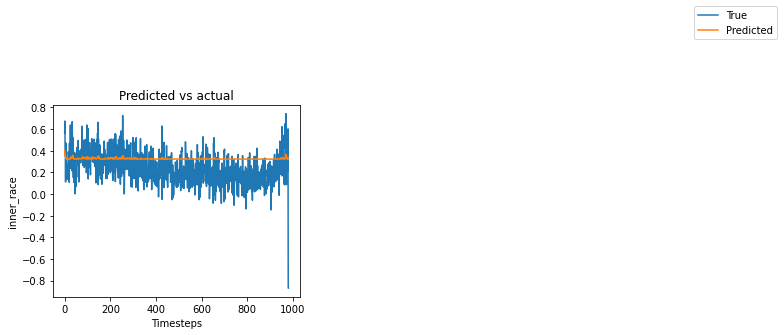

In [175]:
plot_pred_and_actual(inner_race3,model_ir3,ir_scaler3,3,['inner_race'])

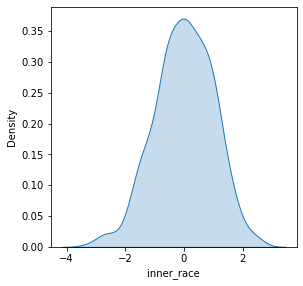

In [176]:
errors_std_ir3,normal_errors_std_ir3 = calc_errors(inner_race3,model_or3,or_scaler3,3,['inner_race'],500)

p-value for errors of feature inner_race: 0.7356643485229102
Do not reject null hypothesis (The distribution of RV is normal)

inner_race


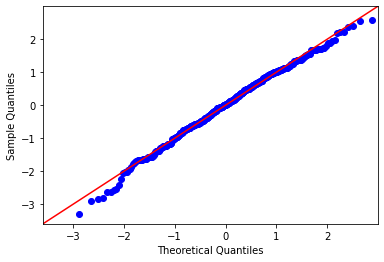

In [177]:
KStest(normal_errors_std_ir3,['inner_race'])
QQPlot(normal_errors_std_ir3,['inner_race'])

### Detecting inner race defect.
No inner race defect detected.

Level 0 warning given at 254th timestep
Level 0 warning dies at 255th timestep
Level 0 warning given at 795th timestep
Level 0 warning dies at 796th timestep
Level 0 warning given at 904th timestep
Level 0 warning dies at 905th timestep
Level 0 warning given at 969th timestep
Level 0 warning dies at 970th timestep
Level 0 warning given at 979th timestep


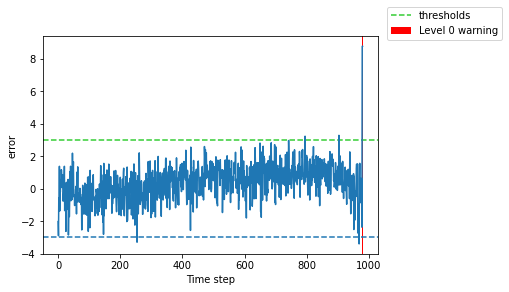

In [178]:
inner_race_defect(normal_errors_std_ir3,errors_std_ir3,True,1,1,12,min_delta=0,verbose=1)